# Сборный проект: Анализ успешности игр.

**Описание проекта:** <br>
Перед нами данные с интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). <br>
**Цель анализа:** <br>
Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**Описание данных:**
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

# Шаг 1. Откроем файлы с данными и изучим общую информацию.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math
import seaborn as sns
from pymystem3 import Mystem
m = Mystem()
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("/datasets/games.csv", sep=",")

print(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


Year_of_Release      NA_sales      EU_sales      JP_sales  \
count     16446.000000  16715.000000  16715.000000  16715.000000   
mean       2006.484616      0.263377      0.145060      0.077617   
std           5.877050      0.813604      0.503339      0.308853   
min        1980.000000      0.000000      0.000000      0.000000   
25%        2003.000000      0.000000      0.000000      0.000000   
50%        2007.000000      0.080000      0.020000      0.000000   
75%        2010.000000      0.240000      0.110000      0.040000   
max        2016.000000     41.360000     28.960000     10.220000   

        Other_sales  Critic_Score  
count  16715.000000   8137.000000  
mean       0.047342     68.967679  
std        0.186731     13.938165  
min        0.000000     13.000000  
25%        0.000000     60.000000  
50%        0.010000     71.000000  
75%        0.030000     79.000000  
max       10.570000     98.000000

**Вывод:** Сразу бросается в глаза наличие пропусков в столбцах. В столбце Years_of_Release нужно будет изменить тип данных в Int64, т.к. год пишут целым числом.

# Шаг 2. Подготовка данных.

# 2.1 Заменим названия столбцов (приведем к нижнему регистру)

In [3]:
print(df.columns)
columns = []
for c in df.columns:
    columns.append(c.lower())
df.columns = columns
print(df.columns)

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')
Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


# 2.2 Изменение типов

In [4]:
df

name platform  year_of_release         genre  \
0                         Wii Sports      Wii           2006.0        Sports   
1                  Super Mario Bros.      NES           1985.0      Platform   
2                     Mario Kart Wii      Wii           2008.0        Racing   
3                  Wii Sports Resort      Wii           2009.0        Sports   
4           Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
...                              ...      ...              ...           ...   
16710  Samurai Warriors: Sanada Maru      PS3           2016.0        Action   
16711               LMA Manager 2007     X360           2006.0        Sports   
16712        Haitaka no Psychedelica      PSV           2016.0     Adventure   
16713               Spirits & Spells      GBA           2003.0      Platform   
16714            Winning Post 8 2016      PSV           2016.0    Simulation   

       na_sales  eu_sales  jp_sales  other_sales  critic_score user_score  \
0         41.36     28.96      3.77         8.45          76.0          8   
1         29.08      3.58      6.81         0.77           NaN        NaN   
2         15.68     12.76      3.79         3.29          82.0        8.3   
3         15.61     10.93      3.28         2.95          80.0          8   
4         11.27      8.89     10.22         1.00           NaN        NaN   
...         ...       ...       ...          ...           ...        ...   
16710      0.00      0.00      0.01         0.00           NaN        NaN   
16711      0.00      0.01      0.00         0.00           NaN        NaN   
16712      0.00      0.00      0.01         0.00           NaN        NaN   
16713      0.01      0.00      0.00         0.00           NaN        NaN   
16714      0.00      0.00      0.01         0.00           NaN        NaN   

      rating  
0          E  
1        NaN  
2          E  
3          E  
4        NaN  
...      ...  
16710    NaN  
16711    NaN  
16712    NaN  
16713    NaN  
16714    NaN  

[16715 rows x 11 columns]

*Поменяем в столбце year_of_release тип на Int64, так как год пишут всегда целым числом.*

In [5]:
df['year_of_release'] = df['year_of_release'].astype('Int64')
df['year_of_release'].dtype

Int64Dtype()

*В других столбцах менять типы данных пока что нет смысла*

# 2.3 Обработка пропусков

# 2.3.1 Столбец `name`

In [6]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().sum())
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (10,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

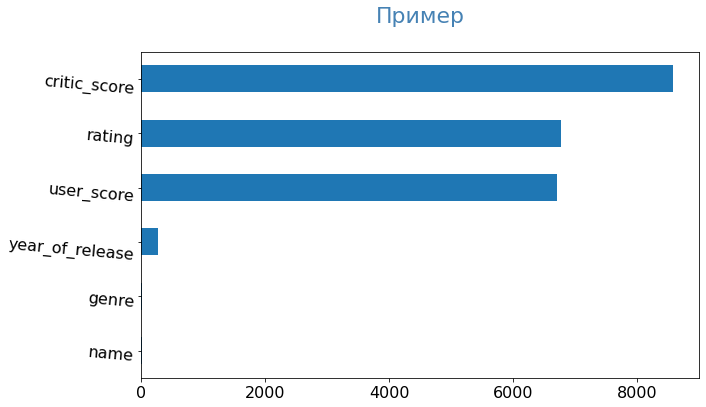

In [7]:
pass_value_barh(df)

*Посмотрим пропущенные значения*

In [8]:
df.query('name.isna()')

name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN             1993   NaN      1.78      0.53      0.00   
14244  NaN      GEN             1993   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  
659           0.08           NaN        NaN    NaN  
14244         0.00           NaN        NaN    NaN

In [9]:
df.query('platform=="GEN" and year_of_release==1993')

name platform  \
659                                                  NaN      GEN   
7885                                    Shining Force II      GEN   
8893                             Super Street Fighter II      GEN   
11986                            Ecco: The Tides of Time      GEN   
12098  Street Fighter II': Special Champion Edition (...      GEN   
12264                                  Streets of Rage 3      GEN   
12984                                    Dynamite Headdy      GEN   
13343                                       Beyond Oasis      GEN   
14244                                                NaN      GEN   

       year_of_release         genre  na_sales  eu_sales  jp_sales  \
659               1993           NaN      1.78      0.53      0.00   
7885              1993      Strategy      0.00      0.00      0.19   
8893              1993      Fighting      0.00      0.00      0.15   
11986             1993     Adventure      0.00      0.00      0.07   
12098             1993        Action      0.00      0.00      0.07   
12264             1993        Action      0.00      0.00      0.07   
12984             1993      Platform      0.00      0.00      0.05   
13343             1993  Role-Playing      0.00      0.00      0.05   
14244             1993           NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  
659           0.08           NaN        NaN    NaN  
7885          0.00           NaN        NaN    NaN  
8893          0.00           NaN        NaN    NaN  
11986         0.00           NaN        NaN    NaN  
12098         0.00           NaN        NaN    NaN  
12264         0.00           NaN        NaN    NaN  
12984         0.00           NaN        NaN    NaN  
13343         0.00           NaN        NaN    NaN  
14244         0.00           NaN        NaN    NaN

*Не вижу возможности узнать имя игр, да и в других столбцах тоже есть пропуски , поэтому удалим эти 2 строки, так как 2 строки против 15 тысяч незначительно мало*

In [10]:
print('До удаления',len(df))
df.dropna(subset=['name'], inplace=True)
df.reset_index(inplace=True,drop=True)
print('После удаления',len(df))

До удаления 16715
После удаления 16713


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.4+ MB


*Хоть названия игр часто бывают оригинальными и возможно не подпадут под лемматизацию, всё же попробуем это сделать, чтобы найти одни и теже имена , которые написаны по разному*

In [12]:
# Функция получает строку - лемматизирует её, затем собирает и возвращает результат
def lemm_list(st):
    w = m.lemmatize(st)
    w.pop()
    return ''.join(w)

df['lemm_name'] = df['name'].apply(lemm_list)
df

name platform  year_of_release         genre  \
0                         Wii Sports      Wii             2006        Sports   
1                  Super Mario Bros.      NES             1985      Platform   
2                     Mario Kart Wii      Wii             2008        Racing   
3                  Wii Sports Resort      Wii             2009        Sports   
4           Pokemon Red/Pokemon Blue       GB             1996  Role-Playing   
...                              ...      ...              ...           ...   
16708  Samurai Warriors: Sanada Maru      PS3             2016        Action   
16709               LMA Manager 2007     X360             2006        Sports   
16710        Haitaka no Psychedelica      PSV             2016     Adventure   
16711               Spirits & Spells      GBA             2003      Platform   
16712            Winning Post 8 2016      PSV             2016    Simulation   

       na_sales  eu_sales  jp_sales  other_sales  critic_score user_score  \
0         41.36     28.96      3.77         8.45          76.0          8   
1         29.08      3.58      6.81         0.77           NaN        NaN   
2         15.68     12.76      3.79         3.29          82.0        8.3   
3         15.61     10.93      3.28         2.95          80.0          8   
4         11.27      8.89     10.22         1.00           NaN        NaN   
...         ...       ...       ...          ...           ...        ...   
16708      0.00      0.00      0.01         0.00           NaN        NaN   
16709      0.00      0.01      0.00         0.00           NaN        NaN   
16710      0.00      0.00      0.01         0.00           NaN        NaN   
16711      0.01      0.00      0.00         0.00           NaN        NaN   
16712      0.00      0.00      0.01         0.00           NaN        NaN   

      rating                      lemm_name  
0          E                     Wii Sports  
1        NaN              Super Mario Bros.  
2          E                 Mario Kart Wii  
3          E              Wii Sports Resort  
4        NaN       Pokemon Red/Pokemon Blue  
...      ...                            ...  
16708    NaN  Samurai Warriors: Sanada Maru  
16709    NaN               LMA Manager 2007  
16710    NaN        Haitaka no Psychedelica  
16711    NaN               Spirits & Spells  
16712    NaN            Winning Post 8 2016  

[16713 rows x 12 columns]

*А теперь посчитаем количество строк `.value_counts()` в обоих столбцах name и lemm_name, если кол-во совпадёт, то повторов нет*

In [13]:
print(len(df['name'].value_counts() ), len(df['lemm_name'].value_counts()))

11559 11558


*Всего 1 значение совпало, то есть в ".value_counts()" оно было = 1, а затем присоединилось к другому*

In [14]:
lemm_name = df['lemm_name'].value_counts()
lemm_name

Need for Speed: Most Wanted         12
LEGO Marvel Super Heroes             9
Ratatouille                          9
Madden NFL 07                        9
FIFA 14                              9
                                    ..
MotorHead                            1
Go Go Ackman 3                       1
Dorabase 2: Nettou Ultra Stadium     1
Princess in Love                     1
Star Fox 64 3D                       1
Name: lemm_name, Length: 11558, dtype: int64

In [15]:
df.reset_index(drop=True)

name platform  year_of_release         genre  \
0                         Wii Sports      Wii             2006        Sports   
1                  Super Mario Bros.      NES             1985      Platform   
2                     Mario Kart Wii      Wii             2008        Racing   
3                  Wii Sports Resort      Wii             2009        Sports   
4           Pokemon Red/Pokemon Blue       GB             1996  Role-Playing   
...                              ...      ...              ...           ...   
16708  Samurai Warriors: Sanada Maru      PS3             2016        Action   
16709               LMA Manager 2007     X360             2006        Sports   
16710        Haitaka no Psychedelica      PSV             2016     Adventure   
16711               Spirits & Spells      GBA             2003      Platform   
16712            Winning Post 8 2016      PSV             2016    Simulation   

       na_sales  eu_sales  jp_sales  other_sales  critic_score user_score  \
0         41.36     28.96      3.77         8.45          76.0          8   
1         29.08      3.58      6.81         0.77           NaN        NaN   
2         15.68     12.76      3.79         3.29          82.0        8.3   
3         15.61     10.93      3.28         2.95          80.0          8   
4         11.27      8.89     10.22         1.00           NaN        NaN   
...         ...       ...       ...          ...           ...        ...   
16708      0.00      0.00      0.01         0.00           NaN        NaN   
16709      0.00      0.01      0.00         0.00           NaN        NaN   
16710      0.00      0.00      0.01         0.00           NaN        NaN   
16711      0.01      0.00      0.00         0.00           NaN        NaN   
16712      0.00      0.00      0.01         0.00           NaN        NaN   

      rating                      lemm_name  
0          E                     Wii Sports  
1        NaN              Super Mario Bros.  
2          E                 Mario Kart Wii  
3          E              Wii Sports Resort  
4        NaN       Pokemon Red/Pokemon Blue  
...      ...                            ...  
16708    NaN  Samurai Warriors: Sanada Maru  
16709    NaN               LMA Manager 2007  
16710    NaN        Haitaka no Psychedelica  
16711    NaN               Spirits & Spells  
16712    NaN            Winning Post 8 2016  

[16713 rows x 12 columns]

In [16]:
def seach_lem(st):
    i = st
    n = df.loc[i,'name']
    n_lem = df.loc[i,'lemm_name']
    if (df.query('name==@n')['name'].count()) != (df.query('lemm_name==@n_lem')['lemm_name'].count()):
        print(i, df.loc[i,'name'], df.loc[i,'lemm_name'])
df.reset_index()['index'].apply(seach_lem)

6444 Love Plus Love Plus
6945 Love Plus + Love Plus


0        None
1        None
2        None
3        None
4        None
         ... 
16708    None
16709    None
16710    None
16711    None
16712    None
Name: index, Length: 16713, dtype: object

In [17]:
df.loc[[6444,6945]]

name platform  year_of_release       genre  na_sales  eu_sales  \
6444    Love Plus       DS             2009  Simulation       0.0       0.0   
6945  Love Plus +       DS             2010  Simulation       0.0       0.0   

      jp_sales  other_sales  critic_score user_score rating  lemm_name  
6444      0.26          0.0           NaN        NaN    NaN  Love Plus  
6945      0.23          0.0           NaN        NaN    NaN  Love Plus

*Очень странные 2 строки - вроде одна и таже игра, одинаковая платформа, но 2 разных года выпуска 2009 и 2010, да еще и plus+(масло масленное), может это какое-то обновление? А посмотрим что скажет Яндекс по этому поводу?*

http://gamebomb.ru/games/15179 *LovePlus – симулятор знакомств для Nintendo DS, вышедший в 2009 году. После релиза последовали обновления и сиквелы, в том числе игра для iOS.
LovePlus+ – версия игры с новым контентом (выезды на пикники, фитнес-режимы, дни пропуска занятий по болезни, и пр.). Почти всё из оригинальной версии представлено в LovePlus+, наряду со многими новыми способами взаимодействия с девушками. Из оригинальной игры в LovePlus+ можно переносить данные.*

*LovePlus+ и LovePlus - будем считать, что это 2 разные игры. В остальном столбец в порядке*

Удалим новый столбец он больше не пригодится

In [18]:
df.drop('lemm_name', axis=1, inplace=True)
df.head(2)

name platform  year_of_release     genre  na_sales  eu_sales  \
0         Wii Sports      Wii             2006    Sports     41.36     28.96   
1  Super Mario Bros.      NES             1985  Platform     29.08      3.58   

   jp_sales  other_sales  critic_score user_score rating  
0      3.77         8.45          76.0          8      E  
1      6.81         0.77           NaN        NaN    NaN

# 2.3.2 Столбец `platform`

*Пропусков здесь нет, проверим корректность данных*

In [19]:
df['platform'].value_counts().sort_index()

2600     133
3DO        3
3DS      520
DC        52
DS      2151
GB        98
GBA      822
GC       556
GEN       27
GG         1
N64      319
NES       98
NG        12
PC       974
PCFX       1
PS      1197
PS2     2161
PS3     1331
PS4      392
PSP     1209
PSV      430
SAT      173
SCD        6
SNES     239
TG16       2
WS         6
Wii     1320
WiiU     147
X360    1262
XB       824
XOne     247
Name: platform, dtype: int64

*С платформами всё в порядке столбец корректен*

# 2.3.3 Столбец `year_of_release`

In [20]:
df['year_of_release'].value_counts()

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1983      17
1989      17
1990      16
1987      16
1988      15
1985      14
1984      14
1980       9
Name: year_of_release, dtype: Int64

*С данными всё хорошо, займемся пропусками*

In [21]:
display(df[df['year_of_release'].isna()])
print('Кол-во пропусков =', df['year_of_release'].isna().sum())

name platform  year_of_release  \
183                      Madden NFL 2004      PS2             <NA>   
377                     FIFA Soccer 2004      PS2             <NA>   
456           LEGO Batman: The Videogame      Wii             <NA>   
475           wwe Smackdown vs. Raw 2006      PS2             <NA>   
609                       Space Invaders     2600             <NA>   
...                                  ...      ...              ...   
16371  PDC World Championship Darts 2008      PSP             <NA>   
16403                      Freaky Flyers       GC             <NA>   
16446                          Inversion       PC             <NA>   
16456        Hakuouki: Shinsengumi Kitan      PS3             <NA>   
16520                       Virtua Quest       GC             <NA>   

              genre  na_sales  eu_sales  jp_sales  other_sales  critic_score  \
183          Sports      4.26      0.26      0.01         0.71          94.0   
377          Sports      0.59      2.36      0.04         0.51          84.0   
456          Action      1.80      0.97      0.00         0.29          74.0   
475        Fighting      1.57      1.02      0.00         0.41           NaN   
609         Shooter      2.36      0.14      0.00         0.03           NaN   
...             ...       ...       ...       ...          ...           ...   
16371        Sports      0.01      0.00      0.00         0.00          43.0   
16403        Racing      0.01      0.00      0.00         0.00          69.0   
16446       Shooter      0.01      0.00      0.00         0.00          59.0   
16456     Adventure      0.01      0.00      0.00         0.00           NaN   
16520  Role-Playing      0.01      0.00      0.00         0.00          55.0   

      user_score rating  
183          8.5      E  
377          6.4      E  
456          7.9   E10+  
475          NaN    NaN  
609          NaN    NaN  
...          ...    ...  
16371        tbd   E10+  
16403        6.5      T  
16446        6.7      M  
16456        NaN    NaN  
16520        5.5      T  

[269 rows x 11 columns]

Кол-во пропусков = 269


In [22]:
# check
# жизненный срок платформы

years_of_life = df.pivot_table(index='platform',values='year_of_release',aggfunc=['min','max'])
years_of_life.columns=['min','max']
years_of_life['years_of_life']=years_of_life['max']-years_of_life['min']
years_of_life

# years_of_life.sort_values(by = 'years_of_life', ascending = False)

min   max  years_of_life
platform                           
2600      1980  1989              9
3DO       1994  1995              1
3DS       2011  2016              5
DC        1998  2008             10
DS        1985  2013             28
GB        1988  2001             13
GBA       2000  2007              7
GC        2001  2007              6
GEN       1990  1994              4
GG        1992  1992              0
N64       1996  2002              6
NES       1983  1994             11
NG        1993  1996              3
PC        1985  2016             31
PCFX      1996  1996              0
PS        1994  2003              9
PS2       2000  2011             11
PS3       2006  2016             10
PS4       2013  2016              3
PSP       2004  2015             11
PSV       2011  2016              5
SAT       1994  1999              5
SCD       1993  1994              1
SNES      1990  1999              9
TG16      1995  1995              0
WS        1999  2001              2
Wii       2006  2016             10
WiiU      2012  2016              4
X360      2005  2016             11
XB        2000  2008              8
XOne      2013  2016              3

*Удалим пропуски в  столбце `year_of_release`, так как их слишком мало.*

In [23]:
df.dropna(subset=['year_of_release'], inplace=True)

In [24]:
df[df['year_of_release'].isna()]['name'].count()

0

In [25]:
# check
# жизненный срок платформы

years_of_life = df.pivot_table(index='platform',values='year_of_release',aggfunc=['min','max'])
years_of_life.columns=['min','max']
years_of_life['years_of_life']=years_of_life['max']-years_of_life['min']
years_of_life

# years_of_life.sort_values(by = 'years_of_life', ascending = False)

min   max  years_of_life
platform                           
2600      1980  1989              9
3DO       1994  1995              1
3DS       2011  2016              5
DC        1998  2008             10
DS        1985  2013             28
GB        1988  2001             13
GBA       2000  2007              7
GC        2001  2007              6
GEN       1990  1994              4
GG        1992  1992              0
N64       1996  2002              6
NES       1983  1994             11
NG        1993  1996              3
PC        1985  2016             31
PCFX      1996  1996              0
PS        1994  2003              9
PS2       2000  2011             11
PS3       2006  2016             10
PS4       2013  2016              3
PSP       2004  2015             11
PSV       2011  2016              5
SAT       1994  1999              5
SCD       1993  1994              1
SNES      1990  1999              9
TG16      1995  1995              0
WS        1999  2001              2
Wii       2006  2016             10
WiiU      2012  2016              4
X360      2005  2016             11
XB        2000  2008              8
XOne      2013  2016              3

In [26]:
df_lol = df.query('platform == "DS" and year_of_release < 1990')
df_lol

name platform  year_of_release   genre  \
15955  Strongest Tokyo University Shogi DS       DS             1985  Action   

       na_sales  eu_sales  jp_sales  other_sales  critic_score user_score  \
15955       0.0       0.0      0.02          0.0           NaN        NaN   

      rating  
15955    NaN

In [27]:
df = df[df.name != 'Strongest Tokyo University Shogi DS']

*Удалили аномальное значение*

# 2.3.4 Столбец `genre`

In [28]:
df['genre'].value_counts().sort_index()

Action          3306
Adventure       1293
Fighting         837
Misc            1721
Platform         878
Puzzle           569
Racing          1226
Role-Playing    1481
Shooter         1296
Simulation       857
Sports          2306
Strategy         673
Name: genre, dtype: int64

*Пропусков нет, имена жанров в порядке, хороший столбец. Всё корректно*

# 2.3.5 Столбец `na_sales`

In [29]:
df['na_sales'].describe()

count    16443.000000
mean         0.264028
std          0.818400
min          0.000000
25%          0.000000
50%          0.080000
75%          0.240000
max         41.360000
Name: na_sales, dtype: float64

*Всё корректно*

# 2.3.6 Столбец `eu_sales`

In [30]:
df['eu_sales'].describe()

count    16443.000000
mean         0.145939
std          0.506731
min          0.000000
25%          0.000000
50%          0.020000
75%          0.110000
max         28.960000
Name: eu_sales, dtype: float64

*Всё корректно*

# 2.3.7 Столбец `jp_sales`

In [31]:
df['jp_sales'].describe()

count    16443.000000
mean         0.078491
std          0.311109
min          0.000000
25%          0.000000
50%          0.000000
75%          0.040000
max         10.220000
Name: jp_sales, dtype: float64

*Всё корректно*

# 2.3.8 Столбец `other_sales`

In [32]:
df['other_sales'].describe()

count    16443.000000
mean         0.047597
std          0.188011
min          0.000000
25%          0.000000
50%          0.010000
75%          0.030000
max         10.570000
Name: other_sales, dtype: float64

*Всё корректно*

# 2.3.9 Столбцы `critic_score` и `user_score`

*Обработаем пропуски в этих двух столбцах по одному алгоритму, - в зависимости от продаж: чем больше продажи, тем больше рейтинг*

In [33]:
display(df['critic_score'].describe())
display(df['critic_score'].value_counts())

count    7983.000000
mean       68.994363
std        13.920060
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

70.0    252
71.0    248
75.0    240
80.0    235
73.0    234
       ... 
29.0      3
20.0      3
13.0      1
17.0      1
21.0      1
Name: critic_score, Length: 81, dtype: int64

*Присутствующие данные столбца `critic_score` корректны*

*Рассмотрим столбец `user_score`*

In [34]:
display(df[['user_score']].describe())
display(df['user_score'].value_counts())

user_score
count        9839
unique         96
top           tbd
freq         2376

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
1.1       2
1         2
1.9       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

*Посмотрим в интернете, что значит "tbd"*
https://fb.ru/article/171345/tbd---chto-znachit-eto-sokraschenie
...расшифровывается очень просто - To Be Determined, то есть "Будет определено".
*Выведем на экран строки с "tbd"*

In [35]:
display(df[df['user_score']=="tbd"])

name platform  year_of_release       genre  \
119                     Zumba Fitness      Wii             2010      Sports   
301    Namco Museum: 50th Anniversary      PS2             2005        Misc   
520                   Zumba Fitness 2      Wii             2011      Sports   
645                      uDraw Studio      Wii             2010        Misc   
717                   Just Dance Kids      Wii             2010        Misc   
...                               ...      ...              ...         ...   
16693                 Planet Monsters      GBA             2001      Action   
16695                Bust-A-Move 3000       GC             2003      Puzzle   
16696                Mega Brain Boost       DS             2008      Puzzle   
16702                        Plushees       DS             2008  Simulation   
16704   Men in Black II: Alien Escape       GC             2003     Shooter   

       na_sales  eu_sales  jp_sales  other_sales  critic_score user_score  \
119        3.45      2.59       0.0         0.66           NaN        tbd   
301        2.08      1.35       0.0         0.54          61.0        tbd   
520        1.51      1.03       0.0         0.27           NaN        tbd   
645        1.65      0.57       0.0         0.20          71.0        tbd   
717        1.52      0.54       0.0         0.18           NaN        tbd   
...         ...       ...       ...          ...           ...        ...   
16693      0.01      0.00       0.0         0.00          67.0        tbd   
16695      0.01      0.00       0.0         0.00          53.0        tbd   
16696      0.01      0.00       0.0         0.00          48.0        tbd   
16702      0.01      0.00       0.0         0.00           NaN        tbd   
16704      0.01      0.00       0.0         0.00           NaN        tbd   

      rating  
119        E  
301     E10+  
520        T  
645        E  
717        E  
...      ...  
16693      E  
16695      E  
16696      E  
16702      E  
16704      T  

[2376 rows x 11 columns]

*Было предположение, что это рейтинги игр, вышедших в последний год, - поэтому рейтинг и не определен. Но предположение оказалось ложным. Закономерность появления "tbd" не прослеживается. Поэтому заменим их на NaN и тогда уже обработаем оба столбца вместе. Также поменяемн тип на float*

In [36]:
print("В 'user_score' Nan было =", df['user_score'].isna().sum())
df.loc[df['user_score']=="tbd", 'user_score']=np.nan
df['user_score'] = df['user_score'].astype(float)

В 'user_score' Nan было = 6604


In [37]:
print("В 'user_score' Nan стало =", df['user_score'].isna().sum())
display(df['user_score'].value_counts())

В 'user_score' Nan стало = 8980


7.8    322
8.0    285
8.2    276
8.3    252
7.5    249
      ... 
2.3      2
0.7      2
1.1      2
9.7      1
0.0      1
Name: user_score, Length: 95, dtype: int64

In [38]:
df[['critic_score','user_score','na_sales','eu_sales','jp_sales','other_sales']].describe()

critic_score   user_score      na_sales      eu_sales      jp_sales  \
count   7983.000000  7463.000000  16443.000000  16443.000000  16443.000000   
mean      68.994363     7.126330      0.264028      0.145939      0.078491   
std       13.920060     1.499447      0.818400      0.506731      0.311109   
min       13.000000     0.000000      0.000000      0.000000      0.000000   
25%       60.000000     6.400000      0.000000      0.000000      0.000000   
50%       71.000000     7.500000      0.080000      0.020000      0.000000   
75%       79.000000     8.200000      0.240000      0.110000      0.040000   
max       98.000000     9.700000     41.360000     28.960000     10.220000   

        other_sales  
count  16443.000000  
mean       0.047597  
std        0.188011  
min        0.000000  
25%        0.000000  
50%        0.010000  
75%        0.030000  
max       10.570000

*Чтобы заполнить пропуски в `critic_score` и `user_score` найдем удельные значения, для строк где присутствуют данные - сколько продаж (по четырем регионам) приходится на 1 единицу `critic_score` и `user_score`. Затем чтобы найти пропущенное значение в `critic_score` и `user_score` подсчитаем продажи для одной строки и разделим на удельные значения*

In [39]:
critic_full = df.loc[df['critic_score'].isna()==False,['critic_score', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales']]
display(critic_full.head())

for column in critic_full.columns:
    print('Сумма столбца', column, '=', critic_full[column].sum()) # Для интереса выведем суммы в каждом столбце
print()

udel_critic = ( critic_full['na_sales'].sum() + critic_full['eu_sales'].sum() + \
            critic_full['jp_sales'].sum() + critic_full['other_sales'].sum() ) / critic_full['critic_score'].sum()
print("Удельная величина продаж на 1 единицу critic_score =", udel_critic)

critic_score  na_sales  eu_sales  jp_sales  other_sales
0          76.0     41.36     28.96      3.77         8.45
2          82.0     15.68     12.76      3.79         3.29
3          80.0     15.61     10.93      3.28         2.95
6          89.0     11.28      9.14      6.50         2.88
7          58.0     13.96      9.18      2.93         2.84

Сумма столбца critic_score = 550782.0
Сумма столбца na_sales = 2830.26
Сумма столбца eu_sales = 1674.8200000000002
Сумма столбца jp_sales = 446.33
Сумма столбца other_sales = 582.2399999999999

Удельная величина продаж на 1 единицу critic_score = 0.01004689695741691


*Посчитаем среднее от удельных значений для каждой игры где присутствует значение `critic_score`*

In [40]:
udel_mean = ((critic_full['na_sales'] + critic_full['eu_sales'] + critic_full['jp_sales'] + \
             critic_full['other_sales'])/critic_full['critic_score']).mean()
udel_mean

0.009199722062357437

*Получили почти тоже самое - Вполне закономерно*

In [41]:
score_sales = critic_full.set_index(critic_full['na_sales'] + critic_full['eu_sales'] + critic_full['jp_sales'] + \
             critic_full['other_sales'])['critic_score']

score_sales.reset_index().describe()

index  critic_score
count  7983.000000   7983.000000
mean      0.693179     68.994363
std       1.831540     13.920060
min       0.010000     13.000000
25%       0.100000     60.000000
50%       0.250000     71.000000
75%       0.650000     79.000000
max      82.540000     98.000000

*Похоже так заполнить не получится из-зи слишком большой разницы в продажах (от 0,01 до 82,54)*

*Попробуем другой вариант:*

In [42]:
df.corr()

year_of_release  na_sales  eu_sales  jp_sales  other_sales  \
year_of_release         1.000000 -0.092436  0.003982 -0.168588     0.037780   
na_sales               -0.092436  1.000000  0.766545  0.451160     0.638478   
eu_sales                0.003982  0.766545  1.000000  0.435892     0.722678   
jp_sales               -0.168588  0.451160  0.435892  1.000000     0.291560   
other_sales             0.037780  0.638478  0.722678  0.291560     1.000000   
critic_score            0.011411  0.240083  0.221276  0.153474     0.198410   
user_score             -0.267851  0.085549  0.055530  0.126372     0.056935   

                 critic_score  user_score  
year_of_release      0.011411   -0.267851  
na_sales             0.240083    0.085549  
eu_sales             0.221276    0.055530  
jp_sales             0.153474    0.126372  
other_sales          0.198410    0.056935  
critic_score         1.000000    0.579671  
user_score           0.579671    1.000000

*Видно, что наибольшая корреляция для столбцов `critic_score` `иser_score` между собой (0,58 - средняя) - и это логично.*

In [43]:
print('Оба столбца Заполнены(nan=False)',((df['critic_score'].isna()==False) & (df['user_score'].isna()==False)).sum())
print('Оба столбца Пустые(nan=True)',((df['critic_score'].isna()) & (df['user_score'].isna())).sum())
print(f'Максимально сможем заполнить еще ДО {len(df)-8003-7017} строк')

Оба столбца Заполнены(nan=False) 6894
Оба столбца Пустые(nan=True) 7891
Максимально сможем заполнить еще ДО 1423 строк


*Можно составить фрейм/словарь соответствия `critic_score` `user_score` (и наоборот) из тех строк, где значения присутствуют в обоих столбцах*

In [44]:
print('Пустые user_score =', (df['user_score'].isna()==True).sum(),'/ Заполненые critic_score =', \
      (df['critic_score'].isna()==False).sum(), "пересечение =",((df['critic_score'].isna()==True) & \
                                                                 (df['user_score'].isna()==False)).sum())
print('Пустые critic_score =', (df['critic_score'].isna()==True).sum(),'/ Заполненые user_score =', \
      (df['user_score'].isna()==False).sum(), "пересечение =",((df['critic_score'].isna()==False) & \
                                                                 (df['user_score'].isna()==True)).sum())

Пустые user_score = 8980 / Заполненые critic_score = 7983 пересечение = 569
Пустые critic_score = 8460 / Заполненые user_score = 7463 пересечение = 1089


*Создадим таблицу соответствия `critic_score` `user_score` (где присутствуют оба значения)*

# *Заполняем `critic_score`*

In [45]:
critic_user = df.loc[(df['critic_score'].isna()==False) & (df['user_score'].isna()==False), ['critic_score','user_score']]
critic_user = critic_user.sort_values(by='user_score').reset_index(drop=True)
critic_user

critic_score  user_score
0             39.0         0.5
1             36.0         0.5
2             72.0         0.6
3             32.0         0.7
4             28.0         0.9
...            ...         ...
6889          81.0         9.5
6890          86.0         9.5
6891          77.0         9.5
6892          81.0         9.6
6893          83.0         9.6

[6894 rows x 2 columns]

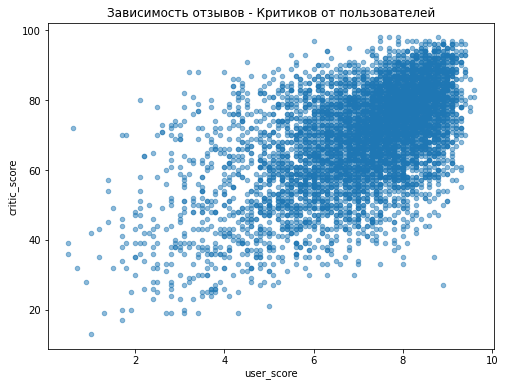

In [46]:
critic_user.plot(x='user_score', y='critic_score', kind='scatter',figsize=(8,6), alpha=0.5);
plt.title('Зависимость отзывов - Критиков от пользователей');

*Корелляция действительно - средненькая ... (зато рисунок напоминает летящую комету)*

In [47]:
def score_search(st):
    us_sc = st['user_score']
    if pd.isna(st['critic_score'])==False:
        return st['critic_score']
    else:
        mark_mean = critic_user.loc[critic_user['user_score'] == us_sc, 'critic_score'].mean()
        if pd.isna(mark_mean):
            up = critic_user.loc[critic_user['user_score'] >= us_sc, 'user_score'].min() # Минимальное из больших
            down = critic_user.loc[critic_user['user_score'] <= us_sc, 'user_score'].max() # Максимальное из меньших   
            mean_critic = ( critic_user.loc[critic_user['user_score'] == up, 'critic_score'].mean() + \
                           critic_user.loc[critic_user['user_score'] == down, 'critic_score'].mean() ) / 2
            return round(mean_critic, 1)
        else:
            return round(mark_mean, 1)

df['critic_score'] = df.apply(score_search, axis=1)

In [48]:
print('Заполненные critic_score =', (df['critic_score'].isna()==False).sum())

Заполненные critic_score = 8546


In [49]:
# check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     8546 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


# *Заполняем `user_score` по аналогии*

In [50]:
critic_user = critic_user.sort_values(by='critic_score').reset_index(drop=True)
critic_user

critic_score  user_score
0             13.0         1.0
1             17.0         1.7
2             19.0         4.3
3             19.0         2.8
4             19.0         3.1
...            ...         ...
6889          97.0         8.5
6890          98.0         7.7
6891          98.0         8.8
6892          98.0         7.9
6893          98.0         7.5

[6894 rows x 2 columns]

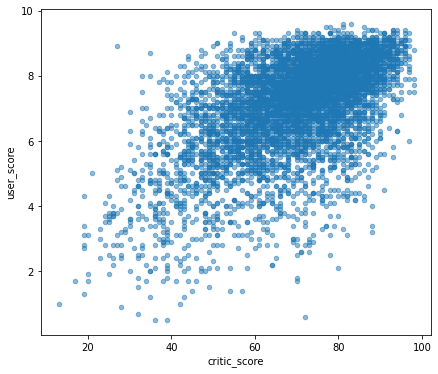

In [51]:
critic_user.plot(y='user_score', x='critic_score', kind='scatter',figsize=(7,6), alpha=0.5); 

In [52]:
def score_search2(st):
    cr_sc = st['critic_score']
    if pd.isna(st['user_score'])==False:
        return st['user_score']
    else:
        mark_mean = critic_user.loc[critic_user['critic_score'] == cr_sc, 'user_score'].mean() 
        if pd.isna(mark_mean):
            up = critic_user.loc[critic_user['critic_score'] >= cr_sc, 'critic_score'].min() # Минимальное из больших
            down = critic_user.loc[critic_user['critic_score'] <= cr_sc, 'critic_score'].max() # Максимальное из меньших   
            mean_critic = ( critic_user.loc[critic_user['critic_score'] == up, 'user_score'].mean() + \
                           critic_user.loc[critic_user['critic_score'] == down, 'user_score'].mean() ) / 2
            return round(mean_critic, 1)
        else:
            return round(mark_mean, 1)

df['user_score'] = df.apply(score_search2, axis=1)

In [53]:
print('Заполненные user_score =', (df['user_score'].isna()==False).sum())

Заполненные user_score = 8552


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     8546 non-null   float64
 9   user_score       8552 non-null   float64
 10  rating           9768 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


*Заполнили всё, что возможно. Остальные строки если заполнять какими либо средними, то можно исказить сильно данные. Поэтому оставляем как есть, и будем использовать для анализа то, что имеем.*

# 2.3.10 Столбец `rating`

In [55]:
df.head(10)

name platform  year_of_release         genre  \
0                 Wii Sports      Wii             2006        Sports   
1          Super Mario Bros.      NES             1985      Platform   
2             Mario Kart Wii      Wii             2008        Racing   
3          Wii Sports Resort      Wii             2009        Sports   
4   Pokemon Red/Pokemon Blue       GB             1996  Role-Playing   
5                     Tetris       GB             1989        Puzzle   
6      New Super Mario Bros.       DS             2006      Platform   
7                   Wii Play      Wii             2006          Misc   
8  New Super Mario Bros. Wii      Wii             2009      Platform   
9                  Duck Hunt      NES             1984       Shooter   

   na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score rating  
0     41.36     28.96      3.77         8.45          76.0         8.0      E  
1     29.08      3.58      6.81         0.77           NaN         NaN    NaN  
2     15.68     12.76      3.79         3.29          82.0         8.3      E  
3     15.61     10.93      3.28         2.95          80.0         8.0      E  
4     11.27      8.89     10.22         1.00           NaN         NaN    NaN  
5     23.20      2.26      4.22         0.58           NaN         NaN    NaN  
6     11.28      9.14      6.50         2.88          89.0         8.5      E  
7     13.96      9.18      2.93         2.84          58.0         6.6      E  
8     14.44      6.94      4.70         2.24          87.0         8.4      E  
9     26.93      0.63      0.28         0.47           NaN         NaN    NaN

In [56]:
print(df['rating'].value_counts(), df['rating'].isna().sum())

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
RP         1
AO         1
Name: rating, dtype: int64 6675


*В начале анализа было видно, что в даных достаточно игр которые вышли на разных платформах. Поэтому встречаются одинаковые имена, а игра одна и таже - значит и возрастной рейтинг должен быть один и тот же. Составим словарь имя-рейтинг `name_rating` и заполним в соостветствии с ним пропуски в столбце `rating`*

In [57]:
name_rating = df.set_index("name")['rating'].dropna().to_dict()
def rat(st):
    if pd.isna(st['rating']):
        return name_rating.get(st['name'])
    return st['rating']

df['rating'] = df.apply(rat, axis=1)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     8546 non-null   float64
 9   user_score       8552 non-null   float64
 10  rating           10185 non-null  object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB
None


*Удалось заполнить совсем не много (10185-9768) - 417 пропусков. Оставшиеся пропуски заполнить не вижу возможности (логически/по_смыслу с другими столбцами не связан).*

# *Проверим на всякий случай дубликаты*

In [58]:
df.duplicated().sum()

0

*Как и следовало ожидать - явных дубликатов нет*

In [59]:
df['name'].str.lower()
df[['name', 'platform', 'year_of_release']].duplicated().sum()

1

*В сырой выборке присутствует одна пара неявных дубликатов, поправим*

In [60]:
df.drop_duplicates(subset=('name', 'platform', 'year_of_release'),inplace=True)

In [61]:
df[['name', 'platform', 'year_of_release']].duplicated().sum()

0

<div class="alert alert-da nger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />   
На рабочих проектах стоит искать дубликаты по ключевым столбцам, для примера по сумме параметров: 
   
    ['name', 'platform', 'year_of_release']
    
С обязательным приведением содержимого категориальных колонок к нижнему регистру
        
В сырой выборке имеется 2 строчки неполных дубликатов
        
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html?highlight=duplicat#pandas.DataFrame.duplicated
    

In [62]:
# check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16442 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16442 non-null  object 
 1   platform         16442 non-null  object 
 2   year_of_release  16442 non-null  Int64  
 3   genre            16442 non-null  object 
 4   na_sales         16442 non-null  float64
 5   eu_sales         16442 non-null  float64
 6   jp_sales         16442 non-null  float64
 7   other_sales      16442 non-null  float64
 8   critic_score     8545 non-null   float64
 9   user_score       8551 non-null   float64
 10  rating           10184 non-null  object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


# 2.4 Суммарные продажи во всех регионах - столбец `sales`

In [63]:
df.head(2)

name platform  year_of_release     genre  na_sales  eu_sales  \
0         Wii Sports      Wii             2006    Sports     41.36     28.96   
1  Super Mario Bros.      NES             1985  Platform     29.08      3.58   

   jp_sales  other_sales  critic_score  user_score rating  
0      3.77         8.45          76.0         8.0      E  
1      6.81         0.77           NaN         NaN   None

In [64]:
df['sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head(2)

name platform  year_of_release     genre  na_sales  eu_sales  \
0         Wii Sports      Wii             2006    Sports     41.36     28.96   
1  Super Mario Bros.      NES             1985  Platform     29.08      3.58   

   jp_sales  other_sales  critic_score  user_score rating  sales  
0      3.77         8.45          76.0         8.0      E  82.54  
1      6.81         0.77           NaN         NaN   None  40.24

*Добавили стобец `sales` с суммарными продажами по всем регионам*

# 2.5 ВЫВОД:

*В ходе предобработки в Столбце `name` удалено 2 строки , применяли лемматизацию для поиска схожих имен, но в итоге дубликатов не нашли. Также удалили аномалию с именем `Strongest Tokyo University Shogi DS`*
<br>
*Столбец `year_of_release` - удалили все 269 пропусков, их достаточно малое количество по соотношению ко всей выборке.*
<br>
*Столбец `critic_score` и `user_score` заполнены на ~8,5 тыс строк.*
<br>
*Столбец `rating` - Удалось заполнить совсем не много - 417 пропусков.*
<br>
*Оставшиеся пропуски заполнить не вижу возможности (логически/по_смыслу), если заполнять медианами, средними , то это может непредсказуемо отразиться на результатах будущего анализа данных.*
<br>
*Явных дубликатов не выявленно, неявные - устранили одну пару*
<br>
*Хоть данные очень не полные, придется оставить как есть. Будем использовать для анализа то, что имеем.*
<br>
*По заданию добавлен столбец `sales` с суммой всех продаж в регионах*

# Шаг 3. Исследовательский анализ данных

# 3.1 Сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [65]:
time_release = df.groupby('year_of_release')['name'].count().reset_index()
time_release.columns = ['year', 'quantity']
time_release

year  quantity
0   1980         9
1   1981        46
2   1982        36
3   1983        17
4   1984        14
5   1985        13
6   1986        21
7   1987        16
8   1988        15
9   1989        17
10  1990        16
11  1991        41
12  1992        43
13  1993        60
14  1994       121
15  1995       219
16  1996       263
17  1997       289
18  1998       379
19  1999       338
20  2000       350
21  2001       482
22  2002       829
23  2003       775
24  2004       762
25  2005       939
26  2006      1006
27  2007      1197
28  2008      1427
29  2009      1426
30  2010      1255
31  2011      1136
32  2012       652
33  2013       544
34  2014       581
35  2015       606
36  2016       502

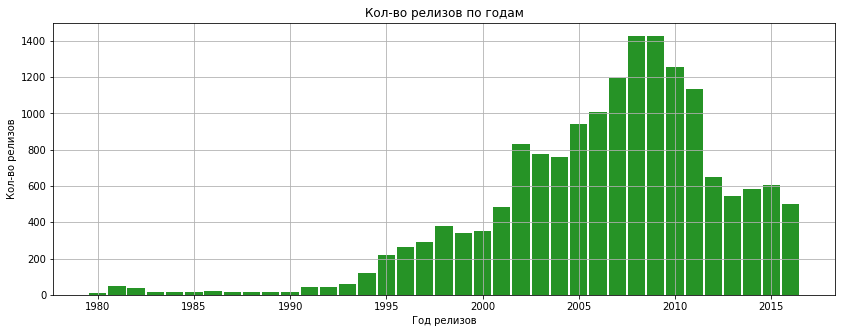

In [66]:
plt.figure(figsize=(14, 5))
plt.bar(time_release['year'], time_release['quantity'], label='Кол-во релизов за год', color='g', alpha=0.85, width=0.9)
plt.xlabel('Год релизов')
plt.ylabel('Кол-во релизов')
plt.grid()
plt.title(f'Кол-во релизов по годам')
plt.show();

**Вывод:** Период до 1994 года характеризуется малой активностью. Хорошо видно, что важный период в релизах игр наступает в 1994 году - и после него начинается бум - компьютерные игры захватывают мир. В 2010 наступает переломный момент и уже в 2012 релизы падают в 2 раза и до 2016 держатся примерно на одно уровне.

# 3.2 Анализ продаж по платформам

In [67]:
plf = df.groupby('platform')['sales'].sum().sort_values().reset_index()
plf

platform    sales
0      PCFX     0.03
1        GG     0.04
2       3DO     0.10
3      TG16     0.16
4        WS     1.42
5        NG     1.44
6       SCD     1.86
7        DC    15.95
8       GEN    28.35
9       SAT    33.59
10      PSV    53.81
11     WiiU    82.19
12     2600    86.48
13     XOne   159.32
14       GC   196.73
15     SNES   200.04
16      N64   218.01
17      NES   251.05
18       XB   251.57
19       GB   254.43
20       PC   255.76
21      3DS   257.81
22      PSP   289.53
23      GBA   312.88
24      PS4   314.14
25       PS   727.58
26       DS   802.76
27      Wii   891.18
28      PS3   931.33
29     X360   961.24
30      PS2  1233.56

*Возьмем около 10 платформ с наибольшими объемами продаж. Построим по ним распределение продаж по годам*

In [68]:
popul_platforms = plf.loc[17:30, 'platform'].values
popul_platforms

array(['NES', 'XB', 'GB', 'PC', '3DS', 'PSP', 'GBA', 'PS4', 'PS', 'DS',
       'Wii', 'PS3', 'X360', 'PS2'], dtype=object)

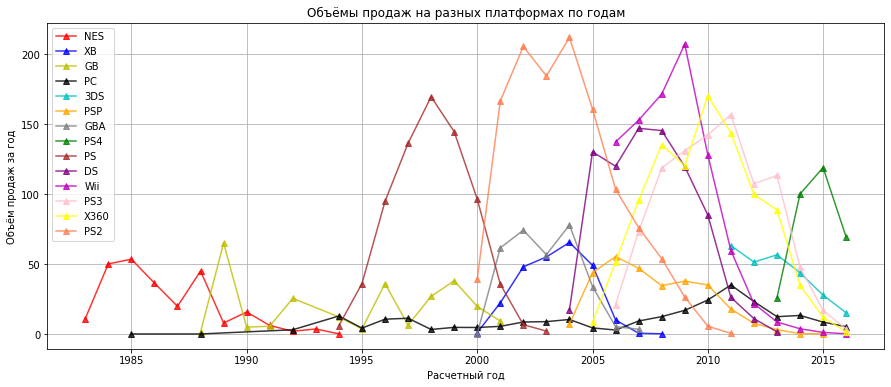

In [69]:
color = ['r','b','y','black','c','orange','grey','green','brown','purple','m','pink','yellow','coral','darkcyan',
         'dimgray','lime']

plt.figure(figsize=(15, 6))
plt.grid()
plt.title('Объёмы продаж на разных платформах по годам')

mean_year_life = 0
for i in range(0,len(popul_platforms)):
    platform  = df.query('platform == @popul_platforms[@i]').groupby('year_of_release')['sales'].sum()
    mean_year_life += platform.count()
    platform.plot(x=platform.index, y=platform.values, style='-^', color=color[i], \
                  label=popul_platforms[i], alpha=0.8, grid=True);
plt.xlabel('Расчетный год')    
plt.ylabel('Объём продаж за год')
plt.legend()
plt.show();

*Подсчитаем срок жизни платформы вручную*

In [70]:
mean_year_life/len(popul_platforms)

11.142857142857142

**Вывод:** Расчетное значение 11,4 года, а из графика видно, что срок активного существования платформ 9-10 лет(если не обращать внимания на минимальные значения по краям), и распределение продаж идет близко к нормальному распределению, поэтому будем считать, что средний срок существования платформы - 10-12 лет. Можно выделить из списка платформ - "PC" (компьютеры, наверное), они хоть и не в топах по выручке, но актуальны во все времена. 

# 3.3 Прогноз на 2017 год

*Актуальный период возьмем с 2014 года.*

In [71]:
actual_df = df.query('2014 <= year_of_release <= 2016') 
actual_df.head()

name platform  year_of_release  \
31                  Call of Duty: Black Ops 3      PS4             2015   
42                         Grand Theft Auto V      PS4             2014   
47  Pokemon Omega Ruby/Pokemon Alpha Sapphire      3DS             2014   
77                                    FIFA 16      PS4             2015   
87               Star Wars Battlefront (2015)      PS4             2015   

           genre  na_sales  eu_sales  jp_sales  other_sales  critic_score  \
31       Shooter      6.03      5.86      0.36         2.38           NaN   
42        Action      3.96      6.31      0.38         1.97          97.0   
47  Role-Playing      4.35      3.49      3.10         0.74           NaN   
77        Sports      1.12      6.12      0.06         1.28          82.0   
87       Shooter      2.99      3.49      0.22         1.28           NaN   

    user_score rating  sales  
31         NaN   None  14.63  
42         8.3      M  12.62  
47         NaN   None  11.68  
77         4.3      E   8.58  
87         NaN   None   7.98

*Посмотрим какие платформы лидируют по продажам, растут или падают. Выберем несколько потенциально прибыльных платформ.*

<AxesSubplot:xlabel='year_of_release', ylabel='platform'>

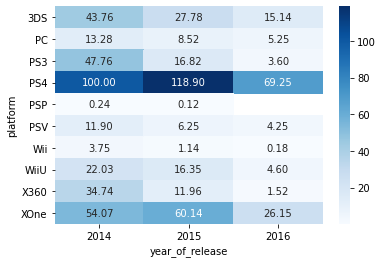

In [72]:
actual_df_pivot = actual_df.pivot_table(index='platform', columns='year_of_release', values = 'sales', aggfunc = 'sum')
sns.heatmap(actual_df_pivot, annot=True, cmap="Blues", fmt='.2f');

***Вывод:** Из полученных данных мы видим, что в топе продаж приставки PS4 и XONE.  <br>
Потенциально прибыльными платформами можем считать: PS4, XONE, 3DS и PC как самую распространенную и долгоживущую платформу.<br>
У PS3 и X360, тоже высокие показатели, но мы их использовать не будем, так как они уже не актуальны.

# 3.4 Глобальные продажи игр в разбивке по платформам

*Возьмем 8 самых продаваемых платформ (в остальных продажи довольно низки)*

In [73]:
df8=actual_df.query('platform == "X360" or platform == "PS3" or platform == "Wii" or platform == "WiiU" or platform == "XOne" or platform == "PS4" or platform == "PC" or platform == "3DS"')

(0.0, 2.0)

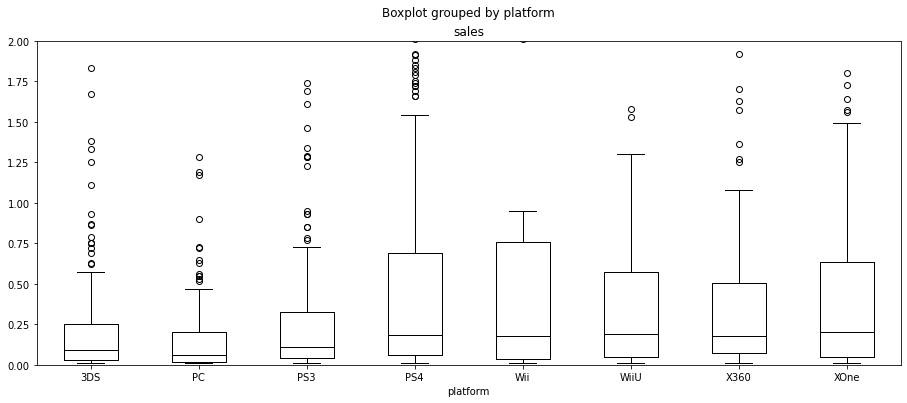

In [74]:
df8.boxplot(column=['sales'], by='platform', grid= False , color='black',figsize=(15,6))
plt.ylim(0,2)

**Вывод:** Заметно, что практически у всех платформ большая часть значений больше медианного. У платформ XONE, X360, WIIU, WII, PS4 медиана находится в районе значения 0.2.
Наиболее длинный ряд упешно продающихся игр у PS4 и XONE, следом WIIU и X360

# 3.5 Продажи внутри одной популярной платформы и отзывы <br> Соотношение с другими платформами

# a) Влияние Продажи-Отзывы на одной популярной платформе

**Выберем для примера популярную платформу "X360"**

In [75]:
one_pl = df.query('platform=="X360"')[['sales', 'critic_score', 'user_score']].dropna().reset_index(drop=True)
one_pl

sales  critic_score  user_score
0    21.82          61.0         6.3
1    16.27          97.0         8.1
2    14.73          88.0         3.4
3    14.62          87.0         6.3
4    13.68          83.0         4.8
..     ...           ...         ...
973   0.01          65.4         6.2
974   0.01          57.0         6.6
975   0.01          62.0         7.0
976   0.01          49.0         2.1
977   0.01          60.8         5.1

[978 rows x 3 columns]

In [76]:
one_pl.corr().round(2)

sales  critic_score  user_score
sales          1.00          0.39        0.11
critic_score   0.39          1.00        0.65
user_score     0.11          0.65        1.00

Коэффициент Зависимости Продаж от отзывов критиков = 0.3879464834130537


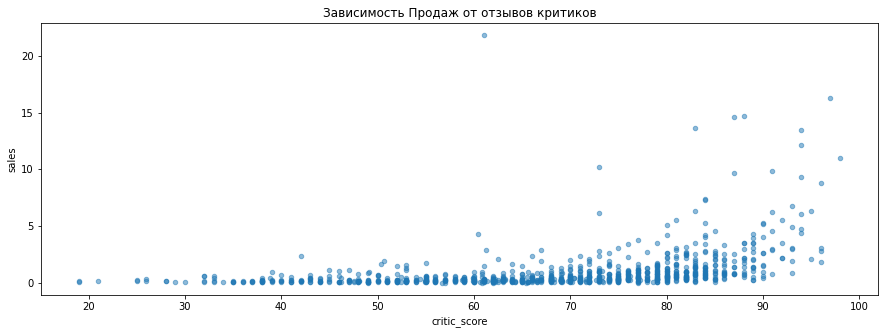

In [77]:
print('Коэффициент Зависимости Продаж от отзывов критиков =' , one_pl['sales'].corr(one_pl['critic_score']))
one_pl.plot(x='critic_score',y='sales',kind='scatter',figsize=(15,5), alpha=0.5)
plt.title('Зависимость Продаж от отзывов критиков');

Коэффициент Зависимости Продаж от отзывов пользователей = 0.1148581528768974


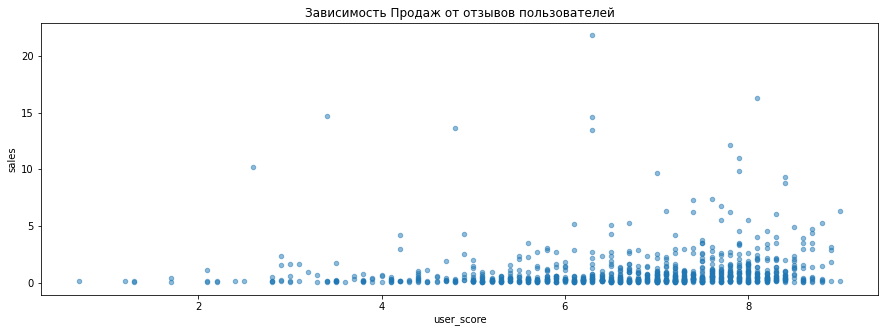

In [78]:
print('Коэффициент Зависимости Продаж от отзывов пользователей =' , one_pl['sales'].corr(one_pl['user_score']))
one_pl.plot(x='user_score',y='sales',kind='scatter',figsize=(15,5), alpha=0.5)
plt.title('Зависимость Продаж от отзывов пользователей');

**Вывод:** По платформе X360: Отзывы критиков важны, хотя зависимость продаж от них находится на уровне средней на границе со слабой(коэффициент 0,39); зависимость здесь прямопропорцианальная - чем выше оценка, тем выше продажи. И зависимость продаж от отзывов пользователей, как выясняется слабая, но ближе к средней, также она прямопропорцианальная(хотя коэффициент значительно меньше - 0,115). В общем зависимости схожи.

# b) Соотношение с другими платформами

*Создадим словарь `sal_scor` - Платформа:DataFrame (с продажами и отзывами)*

In [79]:
sal_scor = {}
for p in df8['platform']:
    sal_scor[p] = df.query('platform==@p')[['sales', 'critic_score', 'user_score']].dropna().reset_index(drop=True)

*Запишем в таблицу `corr8` корелляции продаж с отзывами по топ-8 платформам*

In [80]:
i=0
corr8 = pd.DataFrame(columns=['platform','crit_sale','user_sale'])
for pl_name in sal_scor.keys():
    corr8.loc[i, 'platform'] = pl_name
    corr8.loc[i, 'crit_sale'] = sal_scor[pl_name]['sales'].corr(sal_scor[pl_name]['critic_score'])
    corr8.loc[i, 'user_sale'] = sal_scor[pl_name]['sales'].corr(sal_scor[pl_name]['user_score'])
    i+=1
corr8

platform crit_sale user_sale
0      PS4  0.407268 -0.034007
1      3DS   0.33972  0.227193
2     XOne  0.419562 -0.071318
3     WiiU  0.366296  0.397815
4      PS3  0.416499  0.128109
5     X360  0.387946  0.114858
6       PC  0.255061  0.014255
7      Wii  0.173628  0.117491

*Теперь нарисуем зависимости на графиках*

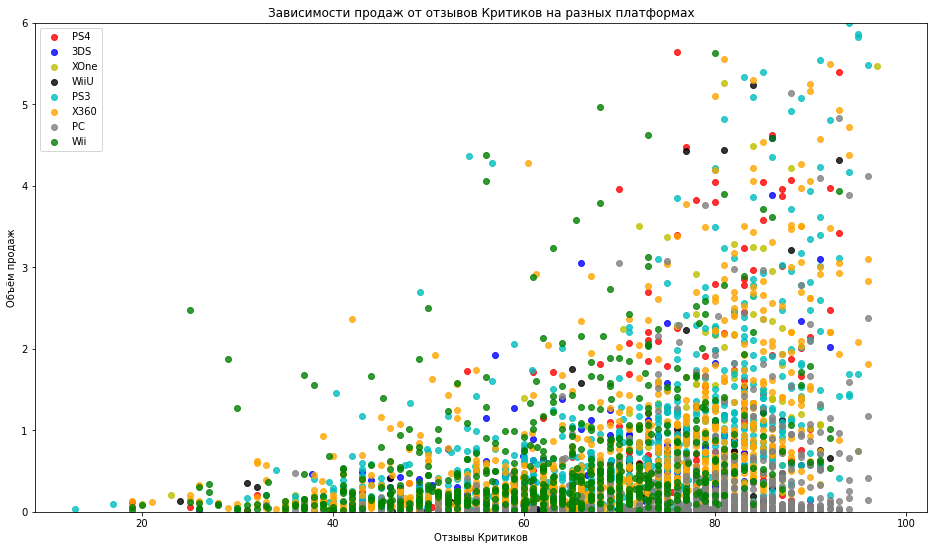

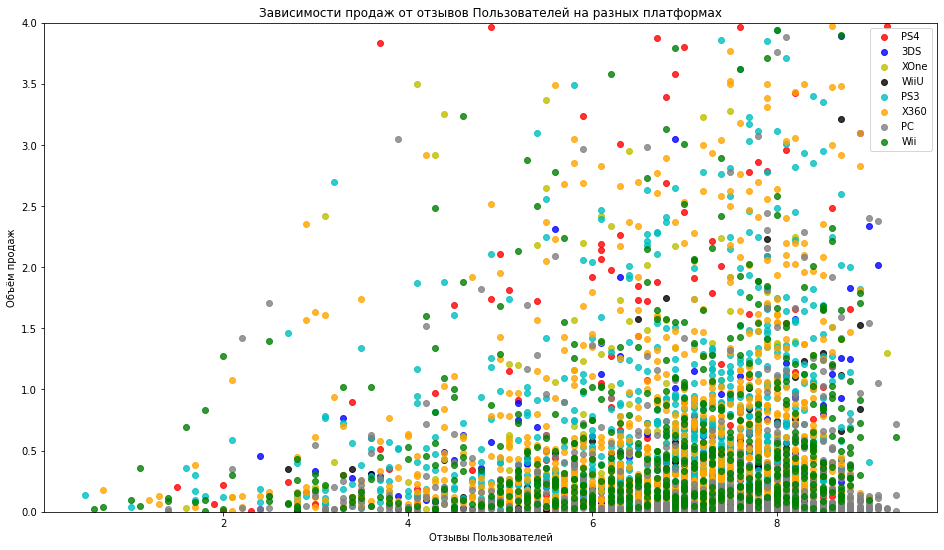

In [81]:
# ==Зависимости продаж от отзывов Критиков
plt.figure(figsize=(16, 9))
plt.grid()
plt.title('Зависимости продаж от отзывов Критиков на разных платформах')
i=0
for p in corr8['platform']:
    xc = sal_scor[p]['critic_score'].to_list()
    yc = sal_scor[p]['sales'].to_list()
    plt.scatter(xc, yc, label=p, color=color[i], alpha=0.8);
    i+=1 
plt.ylim(0,6)
plt.grid()
plt.xlabel('Отзывы Критиков')    
plt.ylabel('Объём продаж')
plt.legend()
plt.show();

# ==Зависимости продаж от отзывов Пользователей
plt.figure(figsize=(16, 9))
plt.grid()
plt.title('Зависимости продаж от отзывов Пользователей на разных платформах')
i=0
for p in corr8['platform']:
    xc = sal_scor[p]['user_score'].to_list()
    yc = sal_scor[p]['sales'].to_list()
    plt.scatter(xc, yc, label=p, color=color[i], alpha=0.8);
    i+=1 
plt.ylim(0,4)
plt.grid()
plt.xlabel('Отзывы Пользователей')    
plt.ylabel('Объём продаж')
plt.legend()
plt.show();

**Вывод:** Схожие тенденции имеют место почти для всех платформ. Зависимость продаж пропорцианальная,- от отзывов критиков слабая, но ближе к средней, а от отзывов пользователей значительно слабее, чем критиков, во многих её почти нет(более менее очень слабая зависимость присутствует в PSP, 3DS и PS2). Надо сказать об отдельных зависимостях: в PS4 - Пользователи не влияют на продажи, В Wii и DS зависимость Критиков очень слабая.

# 3.6 Распределение игр по жанрам

*Кол-во Игр в Жанрах:*

In [82]:
genres = actual_df.groupby('genre')['name'].count().sort_values(ascending=False)
genres

genre
Action          619
Role-Playing    221
Adventure       185
Sports          161
Shooter         128
Misc            113
Racing           69
Fighting         60
Simulation       44
Platform         38
Strategy         37
Puzzle           14
Name: name, dtype: int64

*Отрисуем график*

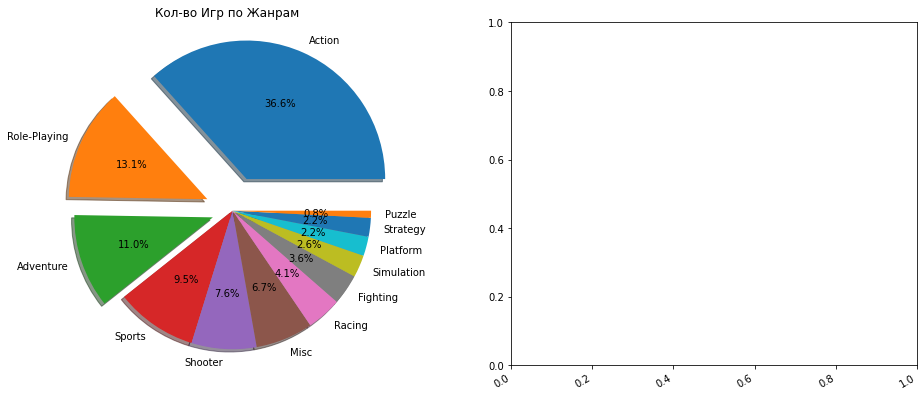

In [83]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
fig.autofmt_xdate();


labels1 = genres.index
sizes1 = genres.values

explode = (0.25, 0.2, 0.15, 0,0,0,0,0,0,0,0,0)
ax1.set_title('Кол-во Игр по Жанрам')
ax1.pie(sizes1, labels=labels1, autopct='%1.1f%%',
        shadow=True, explode=explode,startangle=0)  
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

*Кол-во Продаж по Жанрам:*

In [84]:
genre_sales = actual_df.groupby('genre')[['sales','genre']].sum().sort_values(by='sales',ascending=False)
genre_sales

sales
genre               
Action        199.36
Shooter       170.94
Sports        109.48
Role-Playing  101.44
Misc           37.55
Fighting       28.22
Racing         27.52
Platform       18.09
Adventure      17.55
Simulation     13.13
Strategy        3.96
Puzzle          2.21

*Нарисуем графики*

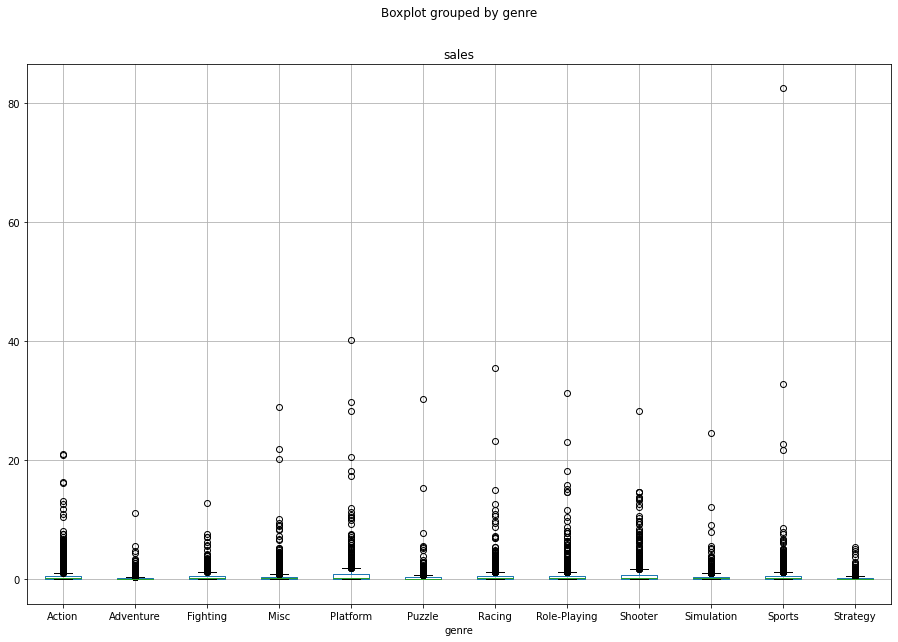

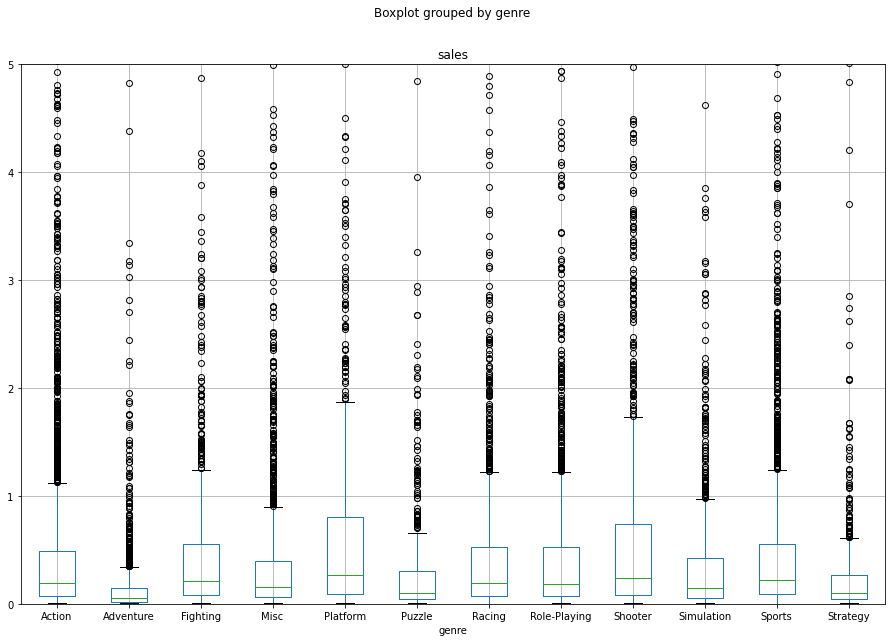

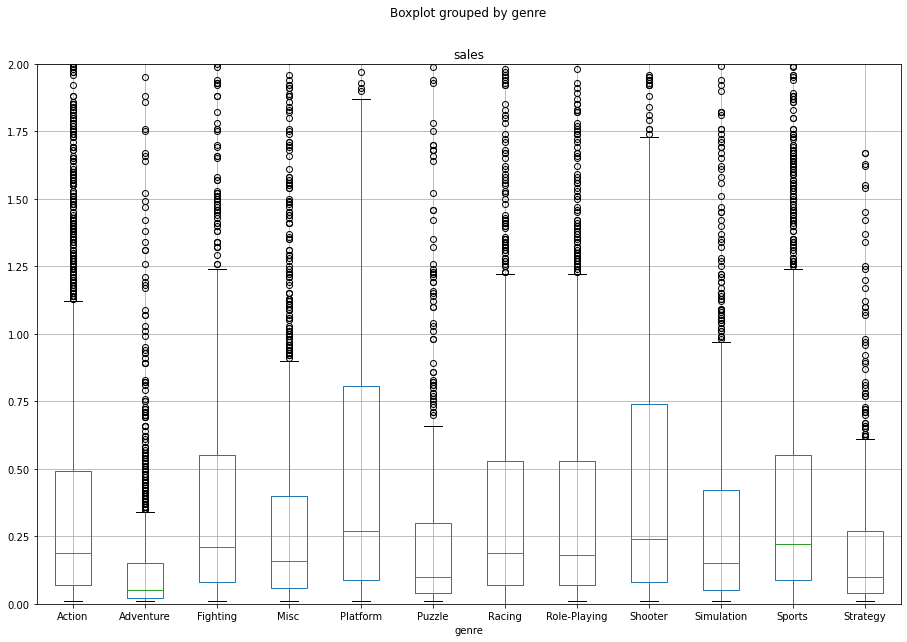

In [85]:
df.boxplot(column='sales', by='genre', figsize=(15, 10))
plt.show()
df.boxplot(column='sales', by='genre', figsize=(15, 10))
plt.ylim(0, 5)
plt.show()
df.boxplot(column='sales', by='genre', figsize=(15, 10))
plt.ylim(0, 2)
plt.show()

In [86]:
actual_df.groupby('genre')['sales'].describe()

count      mean       std   min     25%    50%     75%    max
genre                                                                      
Action        619.0  0.322068  0.798181  0.01  0.0300  0.090  0.2800  12.62
Adventure     185.0  0.094865  0.203147  0.01  0.0200  0.030  0.0800   1.66
Fighting       60.0  0.470333  1.188053  0.01  0.0600  0.125  0.3200   7.55
Misc          113.0  0.332301  0.736999  0.01  0.0300  0.090  0.3200   5.27
Platform       38.0  0.476053  0.722561  0.01  0.0625  0.140  0.4675   3.21
Puzzle         14.0  0.157857  0.320629  0.01  0.0200  0.045  0.1000   1.19
Racing         69.0  0.398841  0.963716  0.01  0.0300  0.090  0.2500   7.09
Role-Playing  221.0  0.459005  1.177284  0.01  0.0500  0.110  0.3600  11.68
Shooter       128.0  1.335469  2.050567  0.01  0.1725  0.515  1.6175  14.63
Simulation     44.0  0.298409  0.646925  0.01  0.0200  0.100  0.3275   3.05
Sports        161.0  0.680000  1.239736  0.01  0.0600  0.180  0.6400   8.58
Strategy       37.0  0.107027  0.118412  0.01  0.0300  0.060  0.1400   0.52

**Вывод:** Общее распределение игр по жанрам с 2014 года - в тройку лидеров входят Action(36,6%), Role-Playing(14%) и Adventure(11%); аутсайдеры здесь Puzzle(0,8%), Strategy(2,2%) и Platform(2,2%).
<br>
Выделяются жанры с высокими и низкими продажами. Заметно, что практически у всех жанров большая часть значений находится больше медианного. Медианы большинства жанров находятся в промежутке от 0.20 до 0.25. Наиболее длинный ряд упешно продающихся игр в жанре shooter и platform.
Больше всего игр в жанре action
Если рассматривать только самые прибыльные жанры, то можно заметить, что в них сочетаются два параметра, у них большое количество игр или высокое медианное значение.

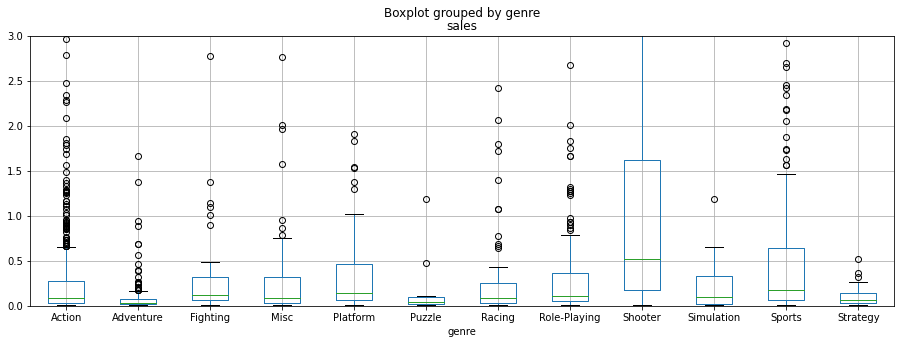

In [87]:
# check
actual_df.boxplot(column='sales', by='genre', figsize=(15, 5))
plt.ylim(0,3);

# Шаг 4. Портрет пользователя каждого региона

# 4.1 Самые популярные платформы в регионах (топ-5)

*Выберем актуальный период для исследования 2014-2016 год и посмотрим на топ-5 платформ.*

In [88]:
actual_df = df.query('2014 <= year_of_release <= 2016') 
actual_df.head()

name platform  year_of_release  \
31                  Call of Duty: Black Ops 3      PS4             2015   
42                         Grand Theft Auto V      PS4             2014   
47  Pokemon Omega Ruby/Pokemon Alpha Sapphire      3DS             2014   
77                                    FIFA 16      PS4             2015   
87               Star Wars Battlefront (2015)      PS4             2015   

           genre  na_sales  eu_sales  jp_sales  other_sales  critic_score  \
31       Shooter      6.03      5.86      0.36         2.38           NaN   
42        Action      3.96      6.31      0.38         1.97          97.0   
47  Role-Playing      4.35      3.49      3.10         0.74           NaN   
77        Sports      1.12      6.12      0.06         1.28          82.0   
87       Shooter      2.99      3.49      0.22         1.28           NaN   

    user_score rating  sales  
31         NaN   None  14.63  
42         8.3      M  12.62  
47         NaN   None  11.68  
77         4.3      E   8.58  
87         NaN   None   7.98

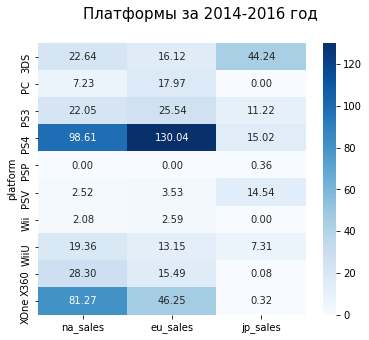

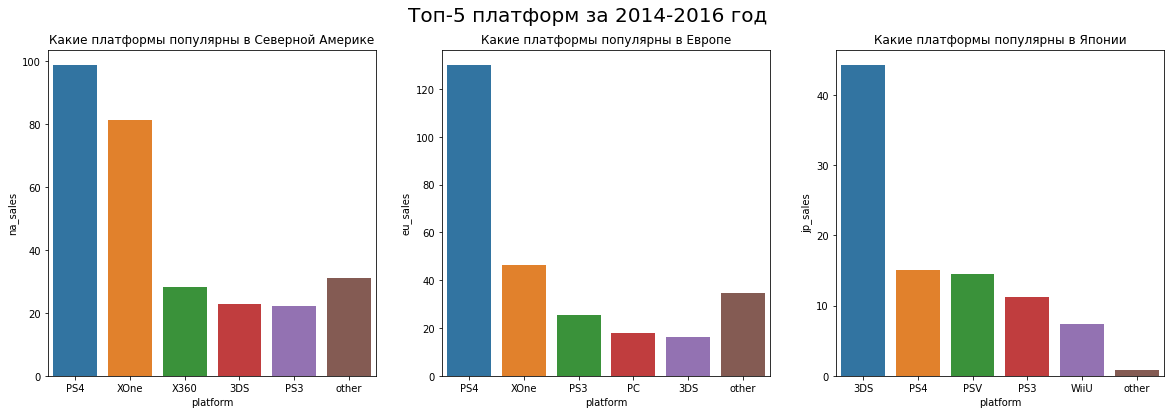

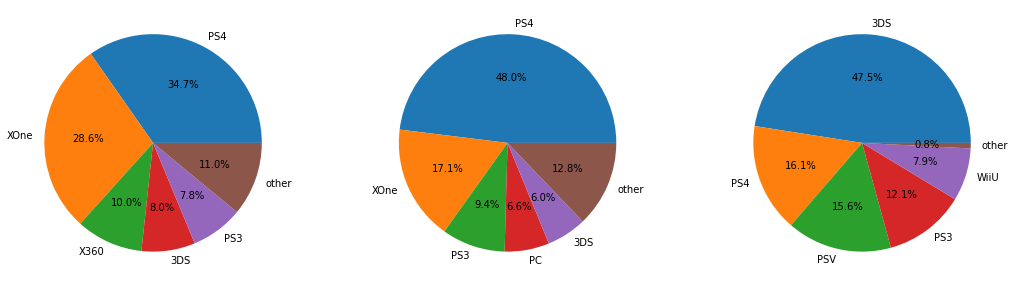

In [89]:
top_platforms = actual_df.groupby('platform')[['na_sales', 'eu_sales', 'jp_sales']].sum()

plt.figure(figsize=(6,5))
plt.suptitle('Платформы за 2014-2016 год', fontsize=15)
sns.heatmap(top_platforms, annot=True, cmap='Blues', fmt='.2f')
plt.show()
print()

columns = top_platforms.columns

#plt.figure(figsize=(15,4))
#i = 1
#for j in columns:
#    plt.subplot (1, 3, i)
#    a = actual_df.groupby('platform')[j].sum().to_frame().nlargest(5, j)
#    sns.barplot(data=a, x=a.index, y=j)
#    i += 1

land = ['Северной Америке', 'Европе', 'Японии']

fig , ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 6))
fig.suptitle('Топ-5 платформ за 2014-2016 год', fontsize=20)
for i in [0, 1, 2]:
    a = actual_df.groupby('platform')[columns[i]].sum().to_frame().sort_values(by = columns[i], ascending=False).reset_index()
    top_5 = a.nlargest(5, columns[i])
    other_value = (a[columns[i]].sum()) - (top_5[columns[i]].sum())
    new_row = {'platform':'other', columns[i]:other_value}
    top_5 = top_5.append(new_row, ignore_index = True)
    sns.barplot(data = top_5, x ='platform', y = columns[i], ax = ax[i])
    ax[i].set_title('Какие платформы популярны в ' + land[i])
plt.show()

fig , ax = plt.subplots(nrows = 1, ncols = 3, figsize=(18,5))
for j in [0, 1, 2]:
    a = actual_df.groupby('platform')[columns[j]].sum().to_frame().sort_values(by = columns[j], ascending=False).reset_index()
    top_5 = a.nlargest(5, columns[j])
    other_value = (a[columns[j]].sum()) - (top_5[columns[j]].sum())
    new_row = {'platform':'other', columns[j]:other_value}
    top_5 = top_5.append(new_row, ignore_index = True)
    ax[j].pie(top_5[columns[j]], labels=top_5['platform'], autopct='%1.1f%%')
plt.show()

**Вывод:** На графиках видно, что PS4 самая популярная платформа в Северной Америке и Европе (доли внутри рынка 34.7% и 48% соответственно), следом идет XONE (28.6% и 17.1%). <br>
В Японии наиболее популярна 3DS(доля от продаж в Японии 47.5%), следом PS4 (16.1%).

*Теперь посмотрим топ-5 самых популярных платформ за все время в каждом регионе*

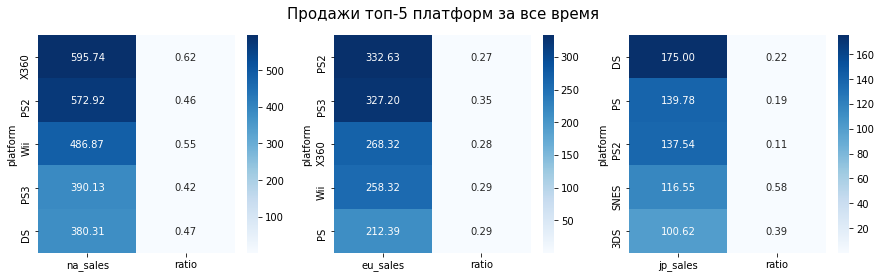

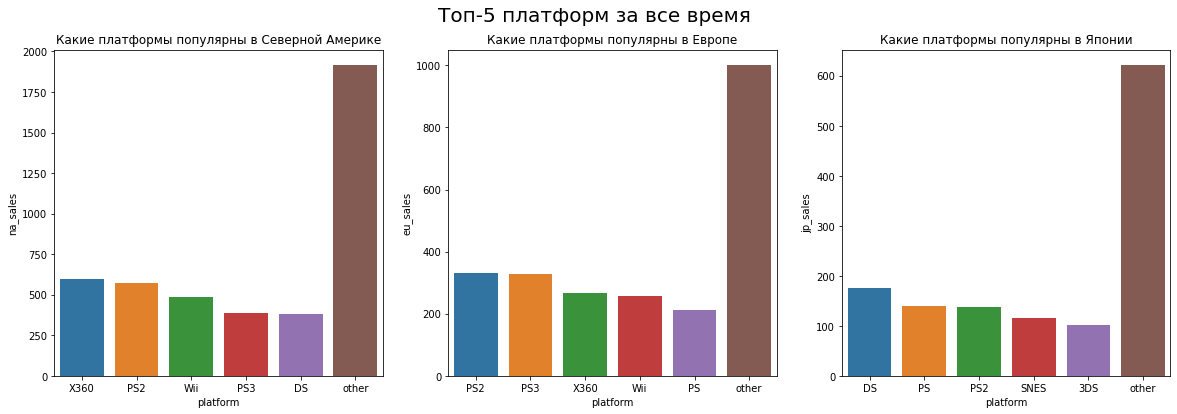

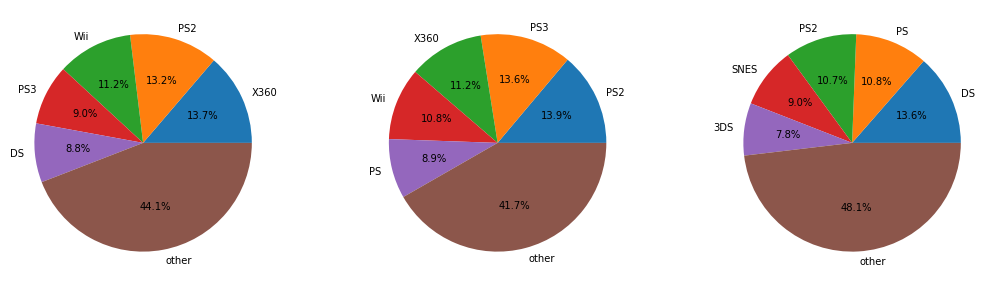

In [90]:
i = 1
plt.figure(figsize=(15,4))
plt.suptitle('Продажи топ-5 платформ за все время', fontsize=15)
for j in columns:
    plt.subplot (1, 3, i)
    a = df.groupby('platform')[j].sum().to_frame().nlargest(5, j)
    a['ratio'] = a[j] / df.groupby('platform')['sales'].sum()
    sns.heatmap(a, annot=True, cmap='Blues', fmt='.2f')
    i += 1
print()


fig , ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 6))
fig.suptitle('Топ-5 платформ за все время', fontsize=20)
for i in [0, 1, 2]:
    a = df.groupby('platform')[columns[i]].sum().to_frame().sort_values(by = columns[i], ascending=False).reset_index()
    top_5 = a.nlargest(5, columns[i])
    other_value = (a[columns[i]].sum()) - (top_5[columns[i]].sum())
    new_row = {'platform':'other', columns[i]:other_value}
    top_5 = top_5.append(new_row, ignore_index = True)
    sns.barplot(data = top_5, x ='platform', y = columns[i], ax = ax[i])
    ax[i].set_title('Какие платформы популярны в ' + land[i])
plt.show()

fig , ax = plt.subplots(nrows = 1, ncols = 3, figsize=(18,5))
for j in [0, 1, 2]:
    a = df.groupby('platform')[columns[j]].sum().to_frame().sort_values(by = columns[j], ascending=False).reset_index()
    top_5 = a.nlargest(5, columns[j])
    other_value = (a[columns[j]].sum()) - (top_5[columns[j]].sum())
    new_row = {'platform':'other', columns[j]:other_value}
    top_5 = top_5.append(new_row, ignore_index = True)
    ax[j].pie(top_5[columns[j]], labels=top_5['platform'], autopct='%1.1f%%')
plt.show()

На североамериканском рынке наибольшим спросом пользовались игры на консолях X360. Доля занимает 62% от объема общемировых продаж по этой консоли.<br>
Внутри рынка у этой консоли доля в 13.7% от всех. Вообще на рынке Америки самые большие доли продаж.<br>

На рынке Европы наибольшим спросом пользовались игры на PS2 и PS3. Доля этих консолей 27% и 35% от общего количества.<br>
Внутри рынка доля составляет 14% и 13.6% соответственно.

В Японии наибольшим спросом пользовались игры на приставках DS. 22% от всех продаж по этой консоли и 13.5% внутри региона.<br>

# 4.2 Самые популярные жанры в регионах (топ-5)

*Посмотрим на популярные жанры в регионах за актуальный период (2014-2016)*

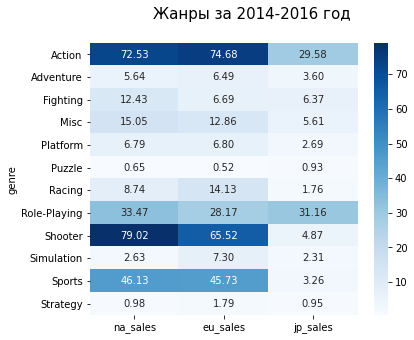

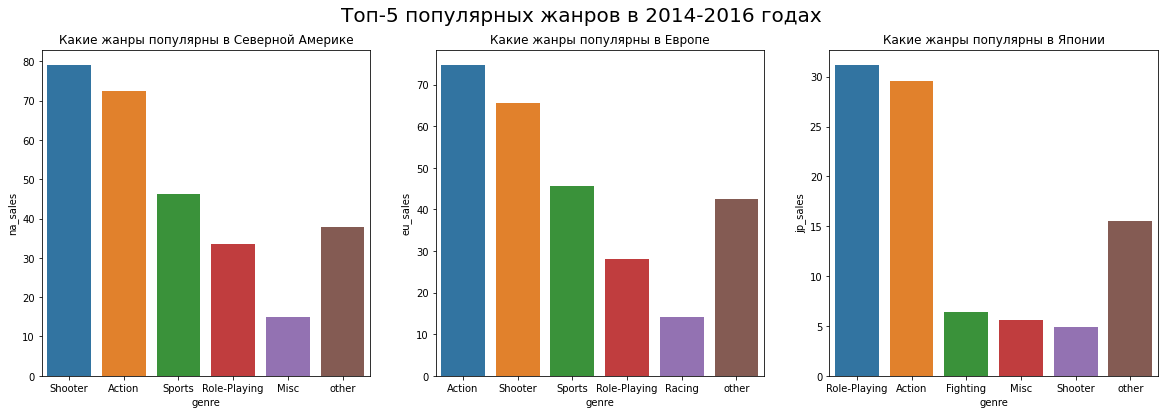

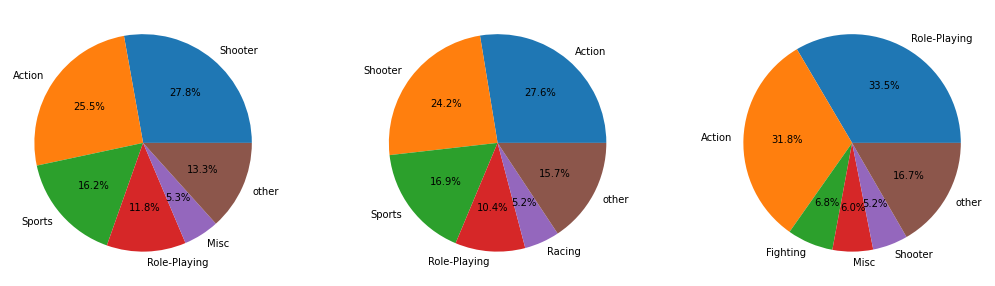

In [91]:
top_genre = actual_df.groupby('genre')[['na_sales', 'eu_sales', 'jp_sales']].sum()

plt.figure(figsize=(6,5))
plt.suptitle('Жанры за 2014-2016 год', fontsize=15)
sns.heatmap(top_genre, annot=True, cmap='Blues', fmt='.2f')
plt.show()
print()

    
fig , ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 6))
fig.suptitle('Топ-5 популярных жанров в 2014-2016 годах', fontsize=20)
for i in [0, 1, 2]:
    a = actual_df.groupby('genre')[columns[i]].sum().to_frame().sort_values(by = columns[i], ascending=False).reset_index()
    top_5 = a.nlargest(5, columns[i])
    other_value = (a[columns[i]].sum()) - (top_5[columns[i]].sum())
    new_row = {'genre':'other', columns[i]:other_value}
    top_5 = top_5.append(new_row, ignore_index = True)
    sns.barplot(data = top_5, x ='genre', y = columns[i], ax = ax[i])
    ax[i].set_title('Какие жанры популярны в ' + land[i])
plt.show()

fig , ax = plt.subplots(nrows = 1, ncols = 3, figsize=(18,5))
for j in [0, 1, 2]:
    a = actual_df.groupby('genre')[columns[j]].sum().to_frame().sort_values(by = columns[j], ascending=False).reset_index()
    top_5 = a.nlargest(5, columns[j])
    other_value = (a[columns[j]].sum()) - (top_5[columns[j]].sum())
    new_row = {'genre':'other', columns[j]:other_value}
    top_5 = top_5.append(new_row, ignore_index = True)
    ax[j].pie(top_5[columns[j]], labels=top_5['genre'], autopct='%1.1f%%')
plt.show()

Наиболее популярный жанр на рынке Америки "shooter" и "action"(доля внутри рынка 27.8% и 25.5%)<br>
В Европе похожая картина, но на первом месте "action" а на втором "shooter" (27.7% и 24.2%). Вообще на этих рынках картина с предпочтениями жанра схожа.<br>
В Японии больше популярны жанры "action" и "role-playing" (31.8% и 33.5% соответственно).

*Взглянем на топ-5 за все время.*

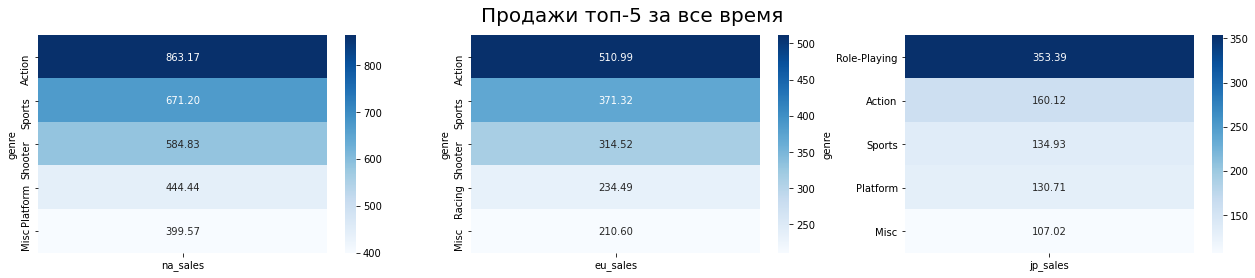

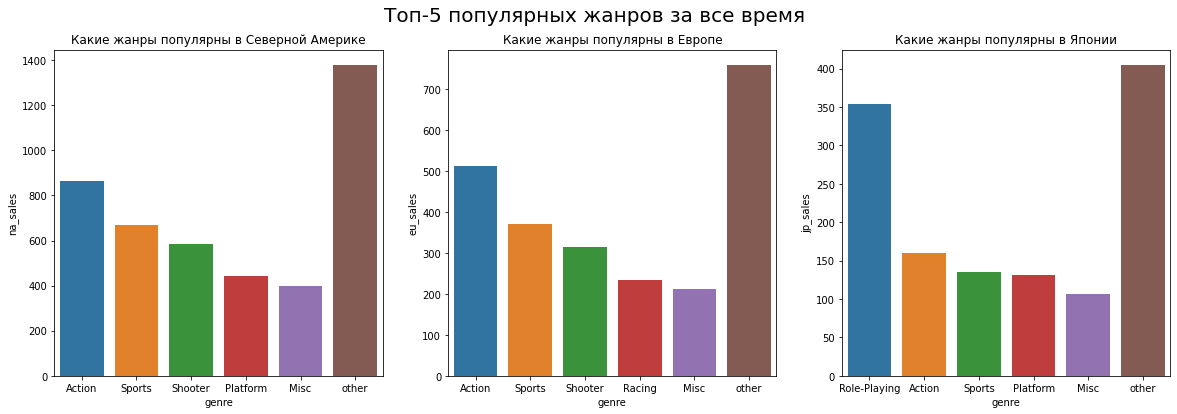

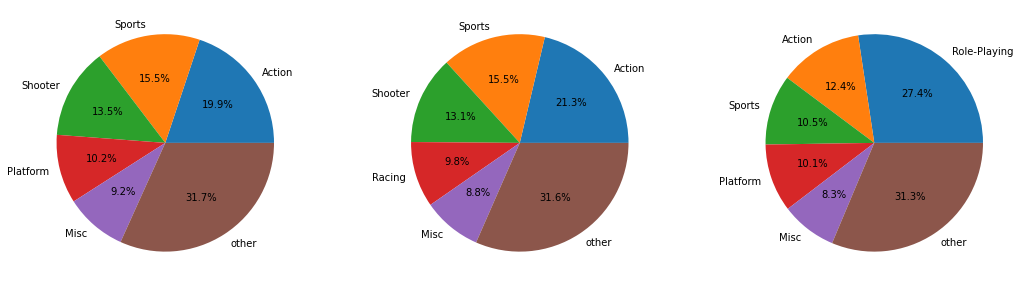

In [92]:
i = 1
plt.figure(figsize=(22,4))
plt.suptitle('Продажи топ-5 за все время', fontsize=20)
for j in columns:
    plt.subplot (1, 3, i)
    a = df.groupby('genre')[j].sum().to_frame().nlargest(5, j)
    sns.heatmap(a, annot=True, cmap='Blues', fmt='.2f')
    i += 1
print()

    
land = ['Северной Америке', 'Европе', 'Японии']
fig , ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 6))
fig.suptitle('Топ-5 популярных жанров за все время', fontsize=20)
for i in [0, 1, 2]:
    a = df.groupby('genre')[columns[i]].sum().to_frame().sort_values(by = columns[i], ascending=False).reset_index()
    top_5 = a.nlargest(5, columns[i])
    other_value = (a[columns[i]].sum()) - (top_5[columns[i]].sum())
    new_row = {'genre':'other', columns[i]:other_value}
    top_5 = top_5.append(new_row, ignore_index = True)
    sns.barplot(data = top_5, x ='genre', y = columns[i], ax = ax[i])
    ax[i].set_title('Какие жанры популярны в ' + land[i])
plt.show()

fig , ax = plt.subplots(nrows = 1, ncols = 3, figsize=(18,5))
for j in [0, 1, 2]:
    a = df.groupby('genre')[columns[j]].sum().to_frame().sort_values(by = columns[j], ascending=False).reset_index()
    top_5 = a.nlargest(5, columns[j])
    other_value = (a[columns[j]].sum()) - (top_5[columns[j]].sum())
    new_row = {'genre':'other', columns[j]:other_value}
    top_5 = top_5.append(new_row, ignore_index = True)
    ax[j].pie(top_5[columns[j]], labels=top_5['genre'], autopct='%1.1f%%')
plt.show()

**Вывод:** На территории Северной Америки и Европы за все время самым популярным жанром был "action" (доля внутри рынка 20% и 21.4% соответственно), далее спортивные игры (доля внутри рынка 15.6% и 15.5%).<br>
В Японии предпочтения почти не меняются. На первом месте "role_playing" (доля внутри рынка 27%) и на втором "action" (12.4%).<br>
По полученным данным можно сказать, что игры в жанре "action" стабильно хорошо востребованы во все временые промежутки и на разных рынках.

# 4.3 Влияние рейтинга ESRB на продажи в отдельных регионах

*Посмотрим влияет ли рейтинг ESRB на продажи в отдельном регионе.* <br>
Возьмем данные за актуальный период.

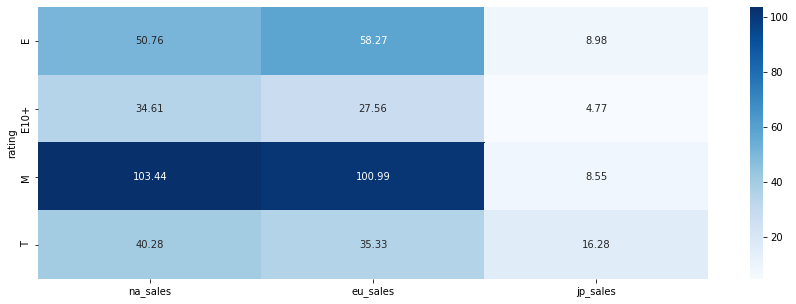

In [93]:
df_esrb = actual_df.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales']].sum()
plt.figure(figsize=(15,5))
sns.heatmap(df_esrb, annot=True, cmap='Blues', fmt='.2f')
plt.show()

**Вывод:** В Европе и Америке наиболее восстребован жанр «M» («Mature») — «Для взрослых», на втором месте «E» («Everyone») — «Для всех».<br>
В Японии на первом месте «T» («Teen») — «Подросткам» и на втором «E» («Everyone») — «Для всех»

# Шаг 5. Проверка гипотез

# 5.1 Гипотеза №1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые (H0:μ1=μ2)

*Сформируем массивы (списки) для обоих платформ*

In [94]:
XOne = df.query(' platform == "XOne"')['user_score'].dropna().to_list()
PC = df.query(' platform == "PC" and year_of_release > 2012')['user_score'].dropna().to_list()

*Подсчитаем дисперсии, чтобы определиться с параметром equal_var*

In [95]:
print('Дисперсия XOne =', np.var(XOne), '// Дисперсия PC =', np.var(PC))

Дисперсия XOne = 1.8620976413458203 // Дисперсия PC = 3.0037323307034844


*Дисперсии отличаются (около 24%), поэтому возьмем equal_var=False*<br>

*Так как нам не нужны сверх точные значения, то укажем критический уровень статистической значимости 5% alpha = 0.05*<br>

*По заданию надо проверить гипотезу: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.*<br>

*Так как H₀ всегда формулируется так, чтобы использовать знак равенства, то нулевую гипотезу сформулируем также (как по заданию): Средние пользовательские рейтинги платформ Xbox One и PC одинаковые (H0:μ1=μ2); альтернативная гипотеза тогда будет такая - Средние пользовательские рейтинги платформ Xbox One и PC различны (H1:μ1 ≠ μ2).*

In [96]:
alpha = 0.05

results = st.ttest_ind(XOne, PC, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.14439034945000395
Не получилось отвергнуть нулевую гипотезу


**Вывод:** Значение p-value больше 14.4%. Опровергнуть нулевую гипотезу не получилось.
Вероятность случайно получить такое или большее различие почти 14.4%.
Можем сделать вывод, что средние пользовательские рейтинги платформ Xbox One и PC схожи

# 5.2 Гипотеза №2. Средние пользовательские рейтинги жанров Action и Sports разные (H1:μ1≠μ2)

*Сформируем массивы (списки) для обоих жанров (так как в столбце `user_score` много пропусков удалим строки, где они присутствуют)*

In [97]:
Action = df.query(' genre == "Action" ')['user_score'].dropna().to_list()
Sports = df.query(' genre == "Sports" ')['user_score'].dropna().to_list()

*Подсчитаем дисперсии, чтобы определиться с параметром equal_var*

In [98]:
print('Дисперсия Action =', np.var(Action), '// Дисперсия Sports =', np.var(Sports))

Дисперсия Action = 1.8871356071235135 // Дисперсия Sports = 2.317208904968598


*Дисперсии отличаются не сильно (около 21%), поэтому возьмем equal_var=True*<br>

*Так как нам не нужны сверх точные значения, то укажем критический уровень статистической значимости 5% alpha = 0.05*<br>

*По заданию надо проверить гипотезу: Средние пользовательские рейтинги жанров Action и Sports разные.*<br>

*Так как H₀ всегда формулируется так, чтобы использовать знак равенства то нулевую гипотезу сформулируем так: Средние пользовательские рейтинги жанров Action и Sports равны (H0:μ1=μ2); альтернативная гипотеза тогда будет такая - Средние пользовательские рейтинги жанров Action и Sports разные (H1:μ1≠μ2).*

In [99]:
alpha = 0.05

results = st.ttest_ind(Action, Sports, equal_var = True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.11797268300184803
Не получилось отвергнуть нулевую гипотезу


**Вывод:** Значение p-value больше 11.8%. Опровергнуть нулевую гипотезу не получилось.
Вероятность случайно получить такое или большее различие почти 11.8%.
Можем сделать вывод, что средние пользовательские рейтинги жанров Action и Sports похожи.

# Шаг 6. Общий вывод

**В ходе предобработки:**<br>

- В ходе предобработки в Столбце `name` удалено 2 строки , применяли лемматизацию для поиска схожих имен, но в итоге дубликатов не нашли. Также удалили аномалию с именем `Strongest Tokyo University Shogi DS`
- Столбец `year_of_release` - удалили все 269 пропусков, их достаточно малое количество по соотношению ко всей выборке.
- Столбец `critic_score` и `user_score` заполнены на ~8,5 тыс строк.
- Столбец `rating` - Удалось заполнить совсем не много - 417 пропусков.
- Оставшиеся пропуски заполнить не вижу возможности (логически/по_смыслу), если заполнять медианами, средними , то это может непредсказуемо отразиться на результатах будущего анализа данных.
- Явных дубликатов не выявленно, неявных - устранена 1 пара
- Хоть данные очень не полные, придется оставить как есть. Будем использовать для анализа то, что имеем.
- По заданию добавлен столбец `sales` с суммой всех продаж в регионах

**В ходе анализа было выявлено:**<br>
- Период до 1994 года характеризуется малой активностью. Хорошо видно, что важный период в релизах игр наступает в 1994 году - и после него начинается бум - компьютерные игры захватывают мир. В 2010 наступает переломный момент и уже в 2012 релизы падают в 2 раза и до 2016 держатся примерно на одном уровне
- Срок активного существования платформ 10-12 лет. Можно выделить из списка платформ - "PC" (компьютеры, наверное), они хоть и не в топах по выручке, но актуальны во все времена. Также надо отметить,что платформа "DS" просуществовала очень долго - до 2013 года.
- для прогноза на 2017 взяли период с 2014 по 2016г. и  из полученных данных мы видим, что в топе продаж приставки PS4 и XONE. По данным видно, что практически все платформы находятся в стадии снижения показателей.Потенциально прибыльными платформами можем считать: PS4, XONE, 3DS и PC как самую распространенную и долгоживущую платформу.У PS3 и X360, тоже высокие показатели, но мы их использовать не будем, так как они уже не актуальны.
- Заметно, что практически у всех платформ большая часть значений больше медианного. У платформ XONE, X360, WIIU, WII, PS4 медиана находится в районе значения 0.2. Наиболее длинный ряд упешно продающихся игр у PS4 и XONE, следом WIIU и Х360.
- По платформе X360: Отзывы критиков важны, хотя зависимость продаж от них находится на уровне средней на границе со слабой(коэффициент 0,39); зависимость здесь прямопропорцианальная - чем выше оценка, тем выше продажи. И зависимость продаж от отзывов пользователей, как выясняется слабая, но ближе к средней, также она прямопропорцианальная(хотя коэффициент значительно меньше - 0,115). В общем зависимости схожи.
- Схожие тенденции имеют место почти для всех платформ. Зависимость продаж пропорцианальная,- от отзывов критиков слабая, но ближе к средней, а от отзывов пользователей значительно слабее, чем критиков, во многих её почти нет(более менее очень слабая зависимость присутствует в PSP, 3DS и PS2). Надо сказать об отдельных зависимостях: в PS4 - Пользователи не влияют на продажи, В Wii и DS зависимость Критиков очень слабая.
- Общее распределение игр по жанрам с 2014 года - в тройку лидеров входят Action(36,6%), Role-Playing(14%) и Adventure(11%); аутсайдеры здесь Puzzle(0,8%), Strategy(2,2%) и Platform(2,2%).
- Выделяются жанры с высокими и низкими продажами. Заметно, что практически у всех жанров большая часть значений находится больше медианного. Медианы большинства жанров находятся в промежутке от 0.20 до 0.25. Наиболее длинный ряд упешно продающихся игр в жанре shooter и platform. Больше всего игр в жанре action Если рассматривать только самые прибыльные жанры, то можно заметить, что в них сочетаются два параметра, у них большое количество игр или высокое медианное значение.

**Портрет пользователя каждого региона:**<br>

- Наиболее популярный жанр на рынке Америки "shooter" и "action"(доля внутри рынка 27.8% и 25.5%)
- В Европе похожая картина, но на первом месте "action" а на втором "shooter" (27.7% и 24.2%). Вообще на этих рынках картина с предпочтениями жанра схожа.
- В Японии больше популярны жанры "action" и "role-playing" (31.8% и 33.5% соответственно).
- По полученным данным можно сказать, что игры в жанре "action" стабильно хорошо востребованы во все временые промежутки и на разных рынках.
- Влияние рейтинга ESRB на продажи в разных регионах почти одинаково. На первом месте «E» и далее «T»,«M» и «E10+»
- В Европе и Америке наиболее восстребован жанр «M» («Mature») — «Для взрослых», на втором месте «E» («Everyone») — «Для всех».
- В Японии на первом месте «T» («Teen») — «Подросткам» и на втором «E» («Everyone») — «Для всех»

**Проверены гипотезы:**<br>

- Средние пользовательские рейтинги платформ Xbox One и PC схожи
- Средние пользовательские рейтинги жанров Action и Sports схожи
<br>*Обе гипотезы не отвергнуты.*